# Stack Overflow Developer Survey 2024: Job Satisfaction & Retention Analysis

## Business Problem & Project Overview

Tech companies face significant challenges in retaining skilled developers, while developers continuously seek fulfilling roles that align with their values and career goals. This project explores the factors that influence job satisfaction and retention in the tech industry using the comprehensive Stack Overflow Developer Survey 2024 dataset.

### Key Research Questions:
1. What factors are most predictive of job satisfaction? (salary, tech stack, remote work, demographics)
2. What signals suggest a developer is likely to look for a new job?
3. Can employers use these insights to improve retention strategies?
4. How can developers assess job fit beyond compensation?

### Target Variables:
- Job Satisfaction (Regression): `JobSat` (satisfaction rating in current role)
- Job Change Intent (Classification): Derived from employment status and job satisfaction patterns

### Ethical Considerations:
- Self-reported data may reflect selection bias (underrepresented groups may be under-sampled)
- Avoid over-generalizing insights to all regions or job types
- Present predictions as supportive insights, not deterministic outcomes

### Dataset Overview:
- Source: Stack Overflow Developer Survey 2024
- Size: 65,000+ developer responses
- Variables: Demographics, career factors, compensation, satisfaction metrics, technology preferences

In [27]:
# Core Data Science Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
import re
import json
import pickle
import hashlib
import time
from functools import wraps

# Statistical Analysis
from scipy import stats
from scipy.stats import chi2_contingency

# Interactive Visualizations
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Scikit-learn - Core ML
import sklearn
from sklearn.model_selection import (
    train_test_split, GridSearchCV, StratifiedShuffleSplit, 
    RandomizedSearchCV, cross_val_score, StratifiedKFold, RepeatedStratifiedKFold
)
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer

# Scikit-learn - Models
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import (
    RandomForestRegressor, RandomForestClassifier,
    VotingClassifier, VotingRegressor, StackingClassifier, StackingRegressor
)

# Scikit-learn - Metrics
from sklearn.metrics import (
    mean_squared_error, mean_absolute_error, r2_score,
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report,
    roc_curve, precision_recall_curve
)
from sklearn.calibration import calibration_curve

# Scikit-learn - Feature Engineering
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_regression, f_classif, RFE, SelectFromModel
from sklearn.inspection import permutation_importance

# Imbalanced Learning
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTETomek, SMOTEENN
from imblearn.pipeline import Pipeline as ImbPipeline

# Advanced ML Libraries
import xgboost as xgb
from xgboost import XGBClassifier, XGBRegressor

import lightgbm as lgb
from lightgbm import LGBMClassifier, LGBMRegressor

import catboost as cb
from catboost import CatBoostClassifier, CatBoostRegressor

# Deep Learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, optimizers, callbacks
from tensorflow.keras.utils import to_categorical

# Model Interpretability
import shap

# MLflow for Experiment Tracking
import mlflow
import mlflow.sklearn
mlflow.set_experiment('job_satisfaction_retention_analysis')

# Configure display and warnings
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

In [28]:
CACHE_DIR = "ml_cache"
if not os.path.exists(CACHE_DIR):
    os.makedirs(CACHE_DIR)

def cache_results(cache_name=None, force_refresh=False):
    """
    Decorator to cache expensive function results
    
    Args:
        cache_name: Custom name for cache file (optional)
        force_refresh: If True, ignore existing cache and recompute
    """
    def decorator(func):
        @wraps(func)
        def wrapper(*args, **kwargs):
            if cache_name:
                filename = f"{cache_name}.pkl"
            else:
                func_id = f"{func.__name__}_{hash(str(args) + str(sorted(kwargs.items())))}"
                filename = f"{func_id}.pkl"
            
            cache_path = os.path.join(CACHE_DIR, filename)
            
            if os.path.exists(cache_path) and not force_refresh:
                print(f"Loading cached results for {func.__name__}")
                try:
                    with open(cache_path, 'rb') as f:
                        return pickle.load(f)
                except Exception as e:
                    print(f"Cache read error: {e}, recomputing...")
            

            print(f"Computing {func.__name__} (this may take a while...)")
            result = func(*args, **kwargs)
            
            try:
                with open(cache_path, 'wb') as f:
                    pickle.dump(result, f)
                print(f"Results cached to {filename}")
            except Exception as e:
                print(f"Cache write error: {e}")
            
            return result
        return wrapper
    return decorator

def clear_cache(pattern=None):
    """Clear cached files"""
    if pattern:
        files = glob.glob(os.path.join(CACHE_DIR, f"*{pattern}*"))
    else:
        files = glob.glob(os.path.join(CACHE_DIR, "*"))
    
    for file in files:
        try:
            os.remove(file)
            print(f"Removed {file}")
        except:
            pass
    print(f"Cleared {len(files)} cache files")

def time_operation(operation_name):
    """Decorator to time operations"""
    def decorator(func):
        @wraps(func)
        def wrapper(*args, **kwargs):
            start_time = time.time()
            print(f"\n{'='*20} {operation_name} {'='*20}")
            result = func(*args, **kwargs)
            elapsed = time.time() - start_time
            print(f"✅ {operation_name} completed in {elapsed:.2f} seconds")
            print(f"{'='*60}\n")
            return result
        return wrapper
    return decorator

print("Caching utilities initialized!")
print(f"Cache directory: {CACHE_DIR}")

Caching utilities initialized!
Cache directory: ml_cache


## Data Import and EDA

In [29]:
data_path = 'stack-overflow-developer-survey-2024/survey_results_public.csv'
schema_path = 'stack-overflow-developer-survey-2024/survey_results_schema.csv'

df = pd.read_csv(data_path, low_memory=False)

schema_df = pd.read_csv(schema_path)

print(f"Dataset shape: {df.shape}")
print(f"Columns: {df.shape[1]}")
print(f"Rows: {df.shape[0]:,}")
df.head(3)

Dataset shape: (65437, 114)
Columns: 114
Rows: 65,437


,ResponseId,MainBranch,Age,Employment,RemoteWork,Check,CodingActivities,EdLevel,LearnCode,LearnCodeOnline,TechDoc,YearsCode,YearsCodePro,DevType,OrgSize,PurchaseInfluence,BuyNewTool,BuildvsBuy,TechEndorse,Country,Currency,CompTotal,LanguageHaveWorkedWith,LanguageWantToWorkWith,LanguageAdmired,DatabaseHaveWorkedWith,DatabaseWantToWorkWith,DatabaseAdmired,PlatformHaveWorkedWith,PlatformWantToWorkWith,PlatformAdmired,WebframeHaveWorkedWith,WebframeWantToWorkWith,WebframeAdmired,EmbeddedHaveWorkedWith,EmbeddedWantToWorkWith,EmbeddedAdmired,MiscTechHaveWorkedWith,MiscTechWantToWorkWith,MiscTechAdmired,ToolsTechHaveWorkedWith,ToolsTechWantToWorkWith,ToolsTechAdmired,NEWCollabToolsHaveWorkedWith,NEWCollabToolsWantToWorkWith,NEWCollabToolsAdmired,OpSysPersonal use,OpSysProfessional use,OfficeStackAsyncHaveWorkedWith,OfficeStackAsyncWantToWorkWith,OfficeStackAsyncAdmired,OfficeStackSyncHaveWorkedWith,OfficeStackSyncWantToWorkWith,OfficeStackSyncAdmired,AISearchDevHaveWorkedWith,AISearchDevWantToWorkWith,AISearchDevAdmired,NEWSOSites,SOVisitFreq,SOAccount,SOPartFreq,SOHow,SOComm,AISelect,AISent,AIBen,AIAcc,AIComplex,AIToolCurrently Using,AIToolInterested in Using,AIToolNot interested in Using,AINextMuch more integrated,AINextNo change,AINextMore integrated,AINextLess integrated,AINextMuch less integrated,AIThreat,AIEthics,AIChallenges,TBranch,ICorPM,WorkExp,Knowledge_1,Knowledge_2,Knowledge_3,Knowledge_4,Knowledge_5,Knowledge_6,Knowledge_7,Knowledge_8,Knowledge_9,Frequency_1,Frequency_2,Frequency_3,TimeSearching,TimeAnswering,Frustration,ProfessionalTech,ProfessionalCloud,ProfessionalQuestion,Industry,JobSatPoints_1,JobSatPoints_4,JobSatPoints_5,JobSatPoints_6,JobSatPoints_7,JobSatPoints_8,JobSatPoints_9,JobSatPoints_10,JobSatPoints_11,SurveyLength,SurveyEase,ConvertedCompYearly,JobSat
0,1,I am a developer by profession,Under 18 years old,"Employed, full-time",Remote,Apples,Hobby,Primary/elementary school,Books / Physical media,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,United States of America,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,I have never visited Stack Overflow or the Sta...,NaN,NaN,NaN,NaN,NaN,Yes,Very favorable,Increase productivity,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,I am a developer by profession,35-44 years old,"Employed, full-time",Remote,Apples,Hobby;Contribute to open-source projects;Other...,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",Books / Physical media;Colleague;On the job tr...,Technical documentation;Blogs;Books;Written Tu...,API document(s) and/or SDK document(s);User gu...,20,17,"Developer, full-stack",NaN,NaN,NaN,NaN,NaN,United Kingdom of Great Britain and Northern I...,NaN,NaN,Bash/Shell (all shells);Go;HTML/CSS;Java;JavaS...,Bash/Shell (all shells);Go;HTML/CSS;Java;JavaS...,Bash/Shell (all shells);Go;HTML/CSS;Java;JavaS...,Dynamodb;MongoDB;PostgreSQL,PostgreSQL,PostgreSQL,Amazon Web Services (AWS);Heroku;Netlify,Amazon Web Services (AWS);Heroku;Netlify,Amazon Web Services (AWS);Heroku;Netlify,Express;Next.js;Node.js;React,Express;Htmx;Node.js;React;Remix,Express;Node.js;React,NaN,NaN,NaN,NaN,NaN,NaN,Docker;Homebrew;Kubernetes;npm;Vite;Webpack,Docker;Homebrew;Kubernetes;npm;Vite;Webpack,Docker;Homebrew;Kubernetes;npm;Vite;Webpack,PyCharm;Visual Studio Code;WebStorm,PyCharm;Visual Studio Code;WebStorm,PyCharm;Visual Studio Code;WebStorm,MacOS;Windows,MacOS,NaN,NaN,NaN,Microsoft Teams;Slack,Slack,Slack,NaN,NaN,NaN,Stack Overflow for Teams (private knowledge sh...,Multiple times per day,Yes,Multiple times per day,Quickly finding code solutions;Finding reliabl...,"Yes, definitely","No, and I don't plan to",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes,Individual contributor,17.0,Agree,Disagree,Agree,Agree,Agree,Neither agree nor disa

In [30]:
# Create mapping from schema for JobSatPoints columns
jobsat_mapping = {}
for _, row in schema_df.iterrows():
    if 'JobSatPoints_' in row['qname']:
        old_name = row['qname']
        question = row['question']
        
        if 'strategy' in question.lower():
            new_name = 'JobSat_Strategy'
        elif 'open source' in question.lower():
            new_name = 'JobSat_OpenSource'
        elif 'securing data' in question.lower():
            new_name = 'JobSat_Security'
        elif 'code quality' in question.lower() or 'quality of code' in question.lower():
            new_name = 'JobSat_CodeQuality'
        elif 'learning' in question.lower() and 'technology' in question.lower():
            new_name = 'JobSat_LearningTech'
        elif 'architecture' in question.lower() or 'designing' in question.lower():
            new_name = 'JobSat_Architecture'
        elif 'power user' in question.lower():
            new_name = 'JobSat_Expertise'
        elif 'hardware' in question.lower():
            new_name = 'JobSat_Hardware'
        elif 'network' in question.lower() and 'observability' in question.lower():
            new_name = 'JobSat_Infrastructure'
        else:
            new_name = f"JobSat_{old_name.split('_')[-1]}"
        
        jobsat_mapping[old_name] = new_name

for old, new in jobsat_mapping.items():
    print(f"  {old} -> {new}")

df = df.rename(columns=jobsat_mapping)

  JobSatPoints_1 -> JobSat_Strategy
  JobSatPoints_4 -> JobSat_OpenSource
  JobSatPoints_5 -> JobSat_Security
  JobSatPoints_6 -> JobSat_CodeQuality
  JobSatPoints_7 -> JobSat_LearningTech
  JobSatPoints_8 -> JobSat_Architecture
  JobSatPoints_9 -> JobSat_Expertise
  JobSatPoints_10 -> JobSat_Hardware
  JobSatPoints_11 -> JobSat_Infrastructure


### Target Variables

In [31]:
target_vars = ['JobSat', 'Employment']

for i, var in enumerate(target_vars, 1):
    print(f"{i}. {var}:")
    print(f"Non-null: {df[var].count():,}, Unique: {df[var].nunique()}")
    print(f"Values: {dict(df[var].value_counts().sort_index())}")
    print()

print(f"Dataset contains {len(df.columns)} columns:")
cols_per_row = 4
for i in range(0, len(df.columns), cols_per_row):
    row_cols = df.columns[i:i+cols_per_row]
    formatted_cols = [f"{j+i+1:3d}.{col}" for j, col in enumerate(row_cols)]
    print(" | ".join(formatted_cols))

1. JobSat:
Non-null: 29,126, Unique: 11
Values: {0.0: 311, 1.0: 276, 2.0: 772, 3.0: 1165, 4.0: 1130, 5.0: 1956, 6.0: 3751, 7.0: 6379, 8.0: 7509, 9.0: 3626, 10.0: 2251}

2. Employment:
Non-null: 65,437, Unique: 110
Values: {'Employed, full-time': 39041, 'Employed, full-time;Employed, part-time': 212, 'Employed, full-time;Independent contractor, freelancer, or self-employed': 3557, 'Employed, full-time;Independent contractor, freelancer, or self-employed;Employed, part-time': 184, 'Employed, full-time;Independent contractor, freelancer, or self-employed;Employed, part-time;Retired': 1, 'Employed, full-time;Independent contractor, freelancer, or self-employed;Not employed, and not looking for work': 2, 'Employed, full-time;Independent contractor, freelancer, or self-employed;Not employed, and not looking for work;Employed, part-time': 2, 'Employed, full-time;Independent contractor, freelancer, or self-employed;Not employed, and not looking for work;Student, part-time': 1, 'Employed, full-

Missing Data Analysis:
Columns with missing data: 109
Top 10 columns with highest missing data percentage:
                                                      Column  Missing_Count  \
AINextMuch less integrated        AINextMuch less integrated          64289   
AINextLess integrated                  AINextLess integrated          63082   
AINextNo change                              AINextNo change          52939   
AINextMuch more integrated        AINextMuch more integrated          51999   
EmbeddedAdmired                              EmbeddedAdmired          48704   
EmbeddedWantToWorkWith                EmbeddedWantToWorkWith          47837   
EmbeddedHaveWorkedWith                EmbeddedHaveWorkedWith          43223   
ConvertedCompYearly                      ConvertedCompYearly          42002   
AIToolNot interested in Using  AIToolNot interested in Using          41023   
AINextMore integrated                  AINextMore integrated          41009   

                       

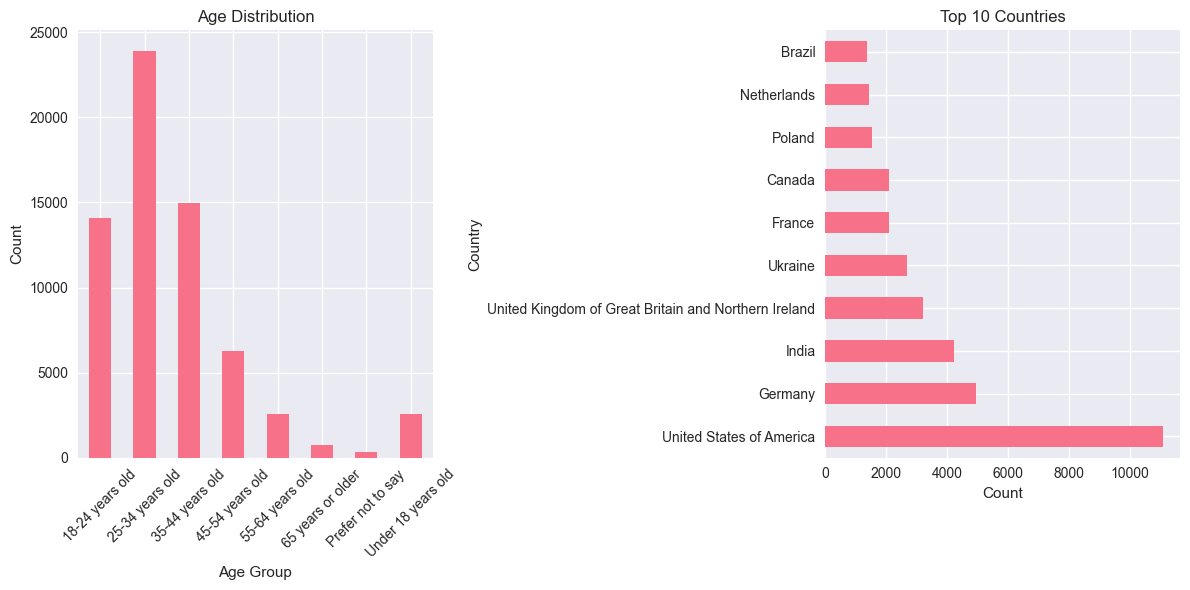


 Career Factors Analysis:

Developer Types (Top 10):
DevType
Developer, full-stack                            18260
Developer, back-end                               9928
Student                                           5102
Developer, front-end                              3349
Developer, desktop or enterprise applications     2493
Other (please specify):                           2458
Developer, mobile                                 2021
Developer, embedded applications or devices       1623
Engineering manager                               1275
Academic researcher                               1238
Name: count, dtype: int64

Years Coding Distribution:
YearsCode
1                      712
10                    4561
11                    1636
12                    2559
13                    1477
14                    1822
15                    2813
16                    1401
17                    1038
18                    1228
19                     561
2                     1642


In [32]:
def analyze_missing_data(df):
    """Analyze missing data patterns"""
    missing_stats = pd.DataFrame({
        'Column': df.columns,
        'Missing_Count': df.isnull().sum(),
        'Missing_Percentage': (df.isnull().sum() / len(df)) * 100
    })
    missing_stats = missing_stats[missing_stats['Missing_Count'] > 0].sort_values('Missing_Percentage', ascending=False)
    return missing_stats

print("Missing Data Analysis:")
missing_data = analyze_missing_data(df)
print(f"Columns with missing data: {len(missing_data)}")
print(f"Top 10 columns with highest missing data percentage:")
print(missing_data.head(10))

print("\n Demographics Analysis:")

if 'Age' in df.columns:
    print(f"\nAge Distribution:")
    age_counts = df['Age'].value_counts().sort_index()
    print(age_counts)
    
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    age_counts.plot(kind='bar')
    plt.title('Age Distribution')
    plt.xlabel('Age Group')
    plt.ylabel('Count')
    plt.xticks(rotation=45)

if 'Country' in df.columns:
    print(f"\nTop 10 Countries by Response Count:")
    country_counts = df['Country'].value_counts().head(10)
    print(country_counts)
    
    plt.subplot(1, 2, 2)
    country_counts.plot(kind='barh')
    plt.title('Top 10 Countries')
    plt.xlabel('Count')
    
plt.tight_layout()
plt.show()

print("\n Career Factors Analysis:")

if 'DevType' in df.columns:
    print(f"\nDeveloper Types (Top 10):")
    dev_types = df['DevType'].dropna().str.split(';').explode().value_counts().head(10)
    print(dev_types)

if 'YearsCode' in df.columns:
    print(f"\nYears Coding Distribution:")
    years_code_counts = df['YearsCode'].value_counts().sort_index()
    print(years_code_counts)

if 'RemoteWork' in df.columns:
    print(f"\nRemote Work Distribution:")
    remote_counts = df['RemoteWork'].value_counts()
    print(remote_counts)


 Compensation Analysis:
Compensation Statistics:
  Count: 23,435
  Mean: $86,155.29
  Median: $65,000.00
  Std: $186,756.97
  Min: $1.00
  Max: $16,256,603.00


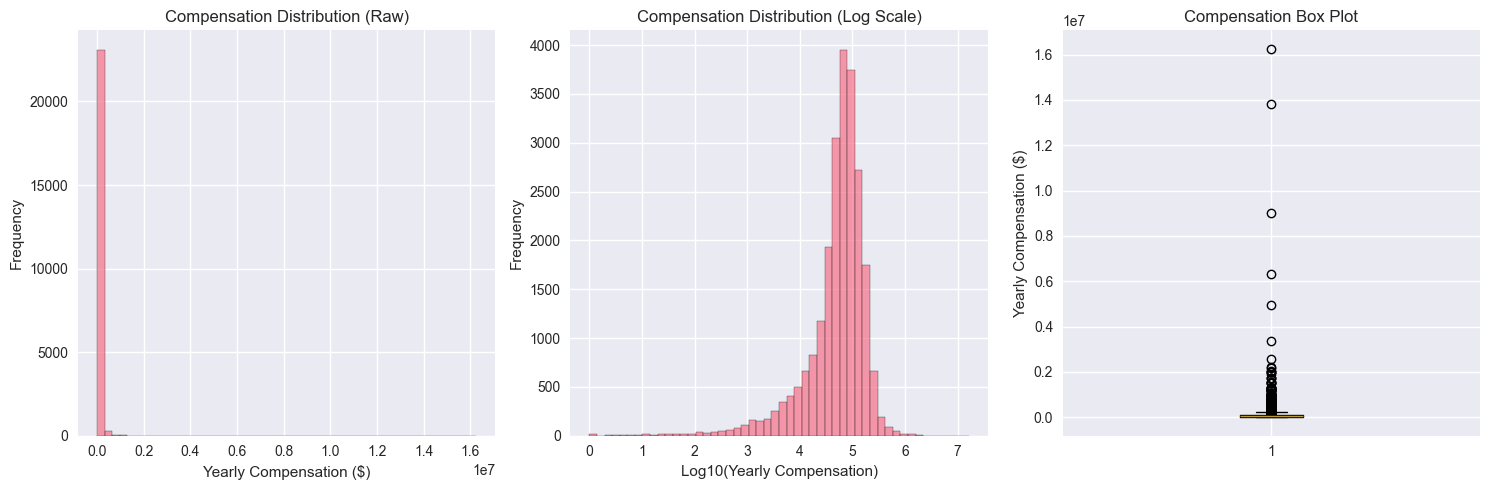

Job Satisfaction Statistics:
  Count: 29,126
  Distribution:
    0.0: 311 (1.1%)
    1.0: 276 (0.9%)
    2.0: 772 (2.7%)
    3.0: 1,165 (4.0%)
    4.0: 1,130 (3.9%)
    5.0: 1,956 (6.7%)
    6.0: 3,751 (12.9%)
    7.0: 6,379 (21.9%)
    8.0: 7,509 (25.8%)
    9.0: 3,626 (12.4%)
    10.0: 2,251 (7.7%)


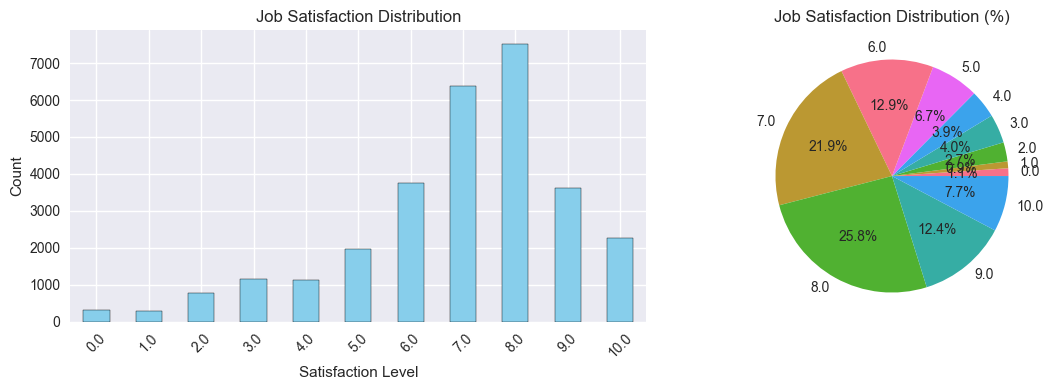


 Correlation Analysis:


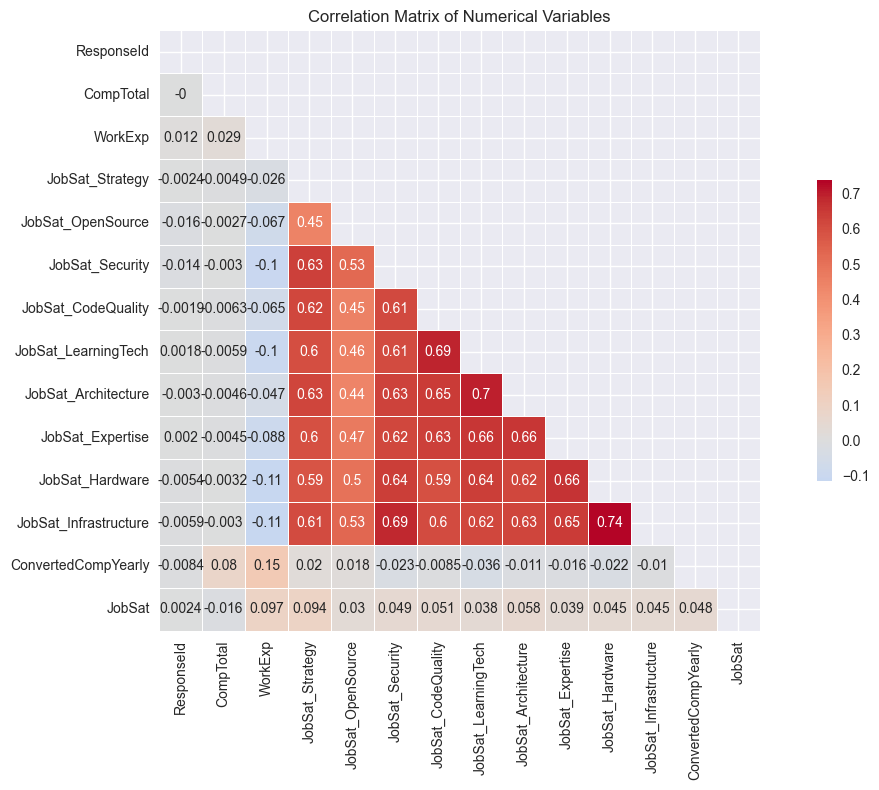

Top 10 strongest correlations (from 91 pairs):
               var1                  var2  correlation
    JobSat_Hardware JobSat_Infrastructure        0.738
JobSat_LearningTech   JobSat_Architecture        0.698
 JobSat_CodeQuality   JobSat_LearningTech        0.692
    JobSat_Security JobSat_Infrastructure        0.691
   JobSat_Expertise       JobSat_Hardware        0.664
JobSat_LearningTech      JobSat_Expertise        0.660
JobSat_Architecture      JobSat_Expertise        0.656
   JobSat_Expertise JobSat_Infrastructure        0.651
 JobSat_CodeQuality   JobSat_Architecture        0.645
    JobSat_Security       JobSat_Hardware        0.644


In [33]:
print("\n Compensation Analysis:")

if 'ConvertedCompYearly' in df.columns:
    comp_data = df['ConvertedCompYearly'].dropna()
    print(f"Compensation Statistics:")
    print(f"  Count: {comp_data.count():,}")
    print(f"  Mean: ${comp_data.mean():,.2f}")
    print(f"  Median: ${comp_data.median():,.2f}")
    print(f"  Std: ${comp_data.std():,.2f}")
    print(f"  Min: ${comp_data.min():,.2f}")
    print(f"  Max: ${comp_data.max():,.2f}")
    
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    plt.hist(comp_data, bins=50, alpha=0.7, edgecolor='black')
    plt.title('Compensation Distribution (Raw)')
    plt.xlabel('Yearly Compensation ($)')
    plt.ylabel('Frequency')
    
    # Log scale for better visualization (a lot of outliers)
    plt.subplot(1, 3, 2)
    log_comp = np.log10(comp_data[comp_data > 0])
    plt.hist(log_comp, bins=50, alpha=0.7, edgecolor='black')
    plt.title('Compensation Distribution (Log Scale)')
    plt.xlabel('Log10(Yearly Compensation)')
    plt.ylabel('Frequency')
    
    plt.subplot(1, 3, 3)
    plt.boxplot(comp_data, vert=True)
    plt.title('Compensation Box Plot')
    plt.ylabel('Yearly Compensation ($)')
    
    plt.tight_layout()
    plt.show()

if 'JobSat' in df.columns:
    jobsat_data = df['JobSat'].dropna()
    print(f"Job Satisfaction Statistics:")
    print(f"  Count: {jobsat_data.count():,}")
    print(f"  Distribution:")
    jobsat_counts = df['JobSat'].value_counts().sort_index()
    for value, count in jobsat_counts.items():
        percentage = (count / jobsat_data.count()) * 100
        print(f"    {value}: {count:,} ({percentage:.1f}%)")
    
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    jobsat_counts.plot(kind='bar', color='skyblue', edgecolor='black')
    plt.title('Job Satisfaction Distribution')
    plt.xlabel('Satisfaction Level')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    
    plt.subplot(1, 2, 2)
    plt.pie(jobsat_counts.values, labels=jobsat_counts.index, autopct='%1.1f%%')
    plt.title('Job Satisfaction Distribution (%)')
    
    plt.tight_layout()
    plt.show()

print("\n Correlation Analysis:")
numerical_cols = df.select_dtypes(include=[np.number]).columns
if len(numerical_cols) > 1:
    corr_matrix = df[numerical_cols].corr()
    
    plt.figure(figsize=(12, 8))
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='coolwarm', 
                center=0, square=True, linewidths=0.5, cbar_kws={"shrink": 0.5})
    plt.title('Correlation Matrix of Numerical Variables')
    plt.tight_layout()
    plt.show()
    
    corr_pairs = []
    for i in range(len(corr_matrix.columns)):
        for j in range(i+1, len(corr_matrix.columns)):
            corr_pairs.append({
                'var1': corr_matrix.columns[i],
                'var2': corr_matrix.columns[j],
                'correlation': corr_matrix.iloc[i, j]
            })
    
    corr_df = pd.DataFrame(corr_pairs)
    corr_df = corr_df.dropna().sort_values('correlation', key=abs, ascending=False)
    print(f"Top 10 strongest correlations (from {len(corr_df)} pairs):")
    print(corr_df.head(10).to_string(index=False, float_format='%.3f'))

## Data Cleaning & Preprocessing

**Cleaning Strategy:**
1. **Missing Values:** Drop features with >50% missing, impute others 
2. **Target Creation:** Create binary job change intent from JobSat (≤5 = likely to change)
3. **Categorical Encoding:** One-hot for few categories, label encoding for many
4. **Outlier Handling:** Remove compensation outliers using IQR method
5. **Feature Selection:** Focus on key predictors identified in EDA

In [34]:
def clean_and_preprocess_data(df):
    """Comprehensive data cleaning function"""

    df_clean = df.copy()
    
    missing_stats = analyze_missing_data(df_clean)
    
    important_cols = ['JobSat', 'ConvertedCompYearly', 'Age', 'Country', 'DevType', 'RemoteWork']
    high_missing = missing_stats[missing_stats['Missing_Percentage'] > 50]['Column'].tolist()
    high_missing = [col for col in high_missing if col not in important_cols]
    
    print(f"Dropping {len(high_missing)} features with >50% missing values")
    if high_missing:
        df_clean = df_clean.drop(columns=high_missing)
    
    # ≤5 = likely to change jobs (dissatisfied), >5 = satisfied
    df_clean['JobChangeIntent'] = (df_clean['JobSat'] <= 5).astype(int)
    change_intent_dist = df_clean['JobChangeIntent'].value_counts()
    print(f"      Satisfied (0): {change_intent_dist.get(0, 0):,} ({change_intent_dist.get(0, 0)/len(df_clean)*100:.1f}%)")
    print(f"      Likely to change (1): {change_intent_dist.get(1, 0):,} ({change_intent_dist.get(1, 0)/len(df_clean)*100:.1f}%)")

    available_cols = df_clean.columns.tolist()
    
    demographic_features = [col for col in ['Age', 'Country', 'EdLevel'] if col in available_cols]
    career_features = [col for col in ['DevType', 'YearsCode', 'YearsCodePro', 'RemoteWork', 'OrgSize', 'Industry'] if col in available_cols]
    compensation_features = [col for col in ['ConvertedCompYearly'] if col in available_cols]
    satisfaction_features = [col for col in available_cols if col.startswith('JobSatPoints_')]
    tech_features = [col for col in ['LanguageHaveWorkedWith', 'DatabaseHaveWorkedWith', 'PlatformHaveWorkedWith'] if col in available_cols]
    
    # Combine all key features
    key_features = demographic_features + career_features + compensation_features + satisfaction_features + tech_features
    
    print(f"Selected features by category:")
    print(f"Demographics: {len(demographic_features)} features")
    print(f"Career: {len(career_features)} features") 
    print(f"Compensation: {len(compensation_features)} features")
    print(f"Satisfaction: {len(satisfaction_features)} features")
    print(f"Technology: {len(tech_features)} features")
    print(f"Total: {len(key_features)} features")
    
    # Add target variables to the feature list
    target_features = ['JobSat', 'JobChangeIntent']
    model_features = key_features + target_features
    
    # Create modeling dataset with available features only
    df_model = df_clean[model_features].copy()
    
    # Handle outliers in compensation
    if 'ConvertedCompYearly' in df_model.columns:
        comp_before = df_model['ConvertedCompYearly'].count()
        
        # Remove extreme outliers using IQR method
        Q1 = df_model['ConvertedCompYearly'].quantile(0.25)
        Q3 = df_model['ConvertedCompYearly'].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = max(1000, Q1 - 1.5 * IQR)  # Don't go below $1000
        upper_bound = Q3 + 1.5 * IQR
        
        df_model.loc[df_model['ConvertedCompYearly'] < lower_bound, 'ConvertedCompYearly'] = np.nan
        df_model.loc[df_model['ConvertedCompYearly'] > upper_bound, 'ConvertedCompYearly'] = np.nan
        
        comp_after = df_model['ConvertedCompYearly'].count()
        print(f"   Compensation outliers removed: {comp_before - comp_after:,} values ({(comp_before - comp_after)/comp_before*100:.1f}%)")
        print(f"   Valid range: ${lower_bound:,.0f} - ${upper_bound:,.0f}")
    
    # Convert categorical columns to category dtype
    categorical_cols = ['Age', 'Country', 'EdLevel', 'DevType', 'RemoteWork', 'OrgSize', 'Industry']
    converted_cols = []
    for col in categorical_cols:
        if col in df_model.columns and df_model[col].dtype == 'object':
            df_model[col] = df_model[col].astype('category')
            converted_cols.append(col)
    
    return df_model

df_processed = clean_and_preprocess_data(df)

print(f"   Original shape: {df.shape}")
print(f"   Processed shape: {df_processed.shape}")
print(f"   Features retained: {df_processed.shape[1] - 2} (plus 2 targets)")

df_processed.head()

Dropping 42 features with >50% missing values
      Satisfied (0): 59,827 (91.4%)
      Likely to change (1): 5,610 (8.6%)
Selected features by category:
Demographics: 3 features
Career: 5 features
Compensation: 1 features
Satisfaction: 0 features
Technology: 3 features
Total: 12 features
   Compensation outliers removed: 1,523 values (6.5%)
   Valid range: $1,000 - $220,861
   Original shape: (65437, 114)
   Processed shape: (65437, 14)
   Features retained: 12 (plus 2 targets)


,Age,Country,EdLevel,DevType,YearsCode,YearsCodePro,RemoteWork,OrgSize,ConvertedCompYearly,LanguageHaveWorkedWith,DatabaseHaveWorkedWith,PlatformHaveWorkedWith,JobSat,JobChangeIntent
0,Under 18 years old,United States of America,Primary/elementary school,NaN,NaN,NaN,Remote,NaN,NaN,NaN,NaN,NaN,NaN,0
1,35-44 years old,United Kingdom of Great Britain and Northern I...,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)","Developer, full-stack",20,17,Remote,NaN,NaN,Bash/Shell (all shells);Go;HTML/CSS;Java;JavaS...,Dynamodb;MongoDB;PostgreSQL,Amazon Web Services (AWS);Heroku;Netlify,NaN,0
2,45-54 years old,United Kingdom of Great Britain and Northern I...,"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",Developer Experience,37,27,Remote,NaN,NaN,C#,Firebase Realtime Database,Google Cloud,NaN,0
3,18-24 years old,Canada,Some college/university study without earning ...,"Developer, full-stack",4,NaN,NaN,NaN,NaN,C;C++;HTML/CSS;Java;JavaScript;PHP;PowerShell;...,MongoDB;MySQL;PostgreSQL;SQLite,Amazon Web Services (AWS);Fly.io;Heroku,NaN,0
4,18-24 years old,Norway,"Secondary school (e.g. American high school, G...","Developer, full-stack",9,NaN,NaN,NaN,NaN,C++;HTML/CSS;JavaScript;Lua;Python;Rust,PostgreSQL;SQLite,NaN,NaN,0


## Feature Engineering

In [35]:
def engineer_features(df):
    df_eng = df.copy()
    
    if 'YearsCode' in df_eng.columns:
        # Convert YearsCode to numeric to handle text responses
        df_eng['YearsCode_numeric'] = pd.to_numeric(df_eng['YearsCode'], errors='coerce')
        
        def categorize_experience(years):
            if pd.isna(years):
                return 'Unknown'
            elif years < 2:
                return 'Beginner'
            elif years < 5:
                return 'Junior'
            elif years < 10:
                return 'Mid-level'
            else:
                return 'Senior'
        
        df_eng['ExperienceLevel'] = df_eng['YearsCode_numeric'].apply(categorize_experience)
        print(f"Experience levels created:")
        exp_dist = df_eng['ExperienceLevel'].value_counts()
        for level, count in exp_dist.items():
            print(f"{level}: {count:,}")
    
    tech_columns = ['LanguageHaveWorkedWith', 'DatabaseHaveWorkedWith', 'PlatformHaveWorkedWith']
    
    for col in tech_columns:
        if col in df_eng.columns:
            score_col = col.replace('HaveWorkedWith', 'Count')
            df_eng[score_col] = df_eng[col].fillna('').str.split(';').str.len()
            df_eng.loc[df_eng[col].isna(), score_col] = 0
            print(f"{score_col}: mean={df_eng[score_col].mean():.1f}, max={df_eng[score_col].max()}")
    
    tech_count_cols = [col.replace('HaveWorkedWith', 'Count') for col in tech_columns if col in df_eng.columns]
    if tech_count_cols:
        df_eng['TechDiversityScore'] = df_eng[tech_count_cols].sum(axis=1)
        print(f"Overall TechDiversityScore: mean={df_eng['TechDiversityScore'].mean():.1f}")
    
    if 'Age' in df_eng.columns:
        def simplify_age(age_str):
            if pd.isna(age_str):
                return 'Unknown'
            elif 'Under 18' in str(age_str):
                return 'Under 25'
            elif '18-24' in str(age_str):
                return 'Under 25'
            elif '25-34' in str(age_str):
                return '25-34'
            elif '35-44' in str(age_str):
                return '35-44'
            elif '45-54' in str(age_str):
                return '45+'
            elif '55-64' in str(age_str):
                return '45+'
            elif '65' in str(age_str) or 'older' in str(age_str):
                return '45+'
            else:
                return 'Unknown'
        
        df_eng['AgeGroup'] = df_eng['Age'].apply(simplify_age)
        age_dist = df_eng['AgeGroup'].value_counts()
        print(f"Simplified age groups:")
        for group, count in age_dist.items():
            print(f"{group}: {count:,}")
    
    if 'RemoteWork' in df_eng.columns:
        df_eng['IsRemote'] = (df_eng['RemoteWork'] == 'Remote').astype(int)
        remote_dist = df_eng['IsRemote'].value_counts()
        print(f"Remote work distribution:")
        print(f"Not Remote (0): {remote_dist.get(0, 0):,}")
        print(f"Remote (1): {remote_dist.get(1, 0):,}")
    
    if 'ConvertedCompYearly' in df_eng.columns:
        comp_data = df_eng['ConvertedCompYearly'].dropna()
        if len(comp_data) > 0:
            # Create quartile-based categories
            quartiles = comp_data.quantile([0.25, 0.5, 0.75])
            
            def categorize_compensation(comp):
                if pd.isna(comp):
                    return 'Unknown'
                elif comp < quartiles[0.25]:
                    return 'Low'
                elif comp < quartiles[0.5]:
                    return 'Mid-Low'
                elif comp < quartiles[0.75]:
                    return 'Mid-High'
                else:
                    return 'High'
            
            df_eng['CompensationCategory'] = df_eng['ConvertedCompYearly'].apply(categorize_compensation)
            comp_dist = df_eng['CompensationCategory'].value_counts()
            for cat, count in comp_dist.items():
                print(f"      {cat}: {count:,}")
            print(f"   Quartile boundaries: ${quartiles[0.25]:,.0f}, ${quartiles[0.5]:,.0f}, ${quartiles[0.75]:,.0f}")
    
    if 'Country' in df_eng.columns:
        top_countries = df_eng['Country'].value_counts().head(10).index.tolist()
        df_eng['CountryGroup'] = df_eng['Country'].apply(
            lambda x: x if x in top_countries else 'Other'
        )
        country_dist = df_eng['CountryGroup'].value_counts()
        print(f"Country groups (Top 10 + Other):")
        print(f"Top countries retained: {len(top_countries)}")
        print(f"Other' group size: {country_dist.get('Other', 0):,}")
    
    return df_eng

# Apply feature engineering
df_features = engineer_features(df_processed)

feature_cols = ['ExperienceLevel', 'TechDiversityScore', 'AgeGroup', 'IsRemote', 'CompensationCategory', 'CountryGroup']
available_feature_cols = [col for col in feature_cols if col in df_features.columns]
if available_feature_cols:
    print(df_features[available_feature_cols].head(10))

Experience levels created:
Senior: 34,632
Mid-level: 16,252
Junior: 7,450
Unknown: 6,391
Beginner: 712
LanguageCount: mean=4.9, max=49
DatabaseCount: mean=2.4, max=35
DatabaseCount: mean=2.4, max=35
PlatformCount: mean=1.5, max=27
Overall TechDiversityScore: mean=8.8
Simplified age groups:
25-34: 23,911
Under 25: 16,666
35-44: 14,942
45+: 9,596
Unknown: 322
Remote work distribution:
Not Remote (0): 44,606
Remote (1): 20,831
      Unknown: 43,525
      Mid-High: 5,625
      High: 5,512
      Low: 5,472
      Mid-Low: 5,303
   Quartile boundaries: $34,370, $64,444, $102,036
Country groups (Top 10 + Other):
Top countries retained: 10
Other' group size: 24,189
  ExperienceLevel  TechDiversityScore  AgeGroup  IsRemote  \
0         Unknown                   0  Under 25         1   
1          Senior                  13     35-44         1   
2          Senior                   3       45+         1   
3          Junior                  17  Under 25         0   
4       Mid-level             

In [ ]:
# Multi-select column preprocessing
def preprocess_multiselect_columns(df, columns_to_process=None, top_n_per_column=15):
    """
    Convert multi-select columns (semicolon-separated) to binary features
    
    Parameters:
    - df: DataFrame to process
    - columns_to_process: List of column names to process (default: auto-detect)
    - top_n_per_column: Number of most common technologies to create binary features for
    
    Returns:
    - processed_df: DataFrame with multi-select columns replaced by binary features
    - feature_mapping: Dictionary mapping original columns to new feature names
    """
    
    if columns_to_process is None:
        columns_to_process = ['LanguageHaveWorkedWith', 'DatabaseHaveWorkedWith', 'PlatformHaveWorkedWith']
    
    # Only process columns that exist in the dataframe
    columns_to_process = [col for col in columns_to_process if col in df.columns]
    
    if not columns_to_process:
        print("No multi-select columns found to process")
        return df.copy(), {}
    
    processed_df = df.copy()
    feature_mapping = {}
    
    def clean_feature_name(name):
        """Clean feature name to be compatible with libraries"""
        # Replace special characters
        name = name.replace(' ', '_').replace('-', '_').replace('/', '_')
        name = name.replace('#', 'Sharp').replace('+', 'Plus').replace('.', '_')
        name = name.replace('(', '').replace(')', '').replace('[', '').replace(']', '')
        name = name.replace('{', '').replace('}', '').replace('<', '').replace('>', '')
        name = name.replace('&', 'and').replace('|', 'or').replace('!', '')
        name = name.replace('?', '').replace('*', '').replace('%', 'percent')
        name = name.replace('$', 'dollar').replace('@', 'at').replace('~', '')
        name = name.replace('^', '').replace('`', '').replace("'", '').replace('"', '')
        name = name.replace(':', '').replace(';', '').replace(',', '').replace('=', 'eq')
        
        # Keep only alphanumeric and underscores
        name = ''.join(c if c.isalnum() or c == '_' else '_' for c in name)
        
        # Remove multiple consecutive underscores
        while '__' in name:
            name = name.replace('__', '_')
        
        # Remove leading/trailing underscores
        name = name.strip('_')
        
        # Ensure it doesn't start with a number
        if name and name[0].isdigit():
            name = 'num_' + name
            
        return name
    
    for col in columns_to_process:
        print(f"Processing {col}...")
        
        # Get all unique technologies from this column
        all_techs = set()
        for value in processed_df[col].dropna():
            if pd.notna(value) and str(value).strip():
                techs = [tech.strip() for tech in str(value).split(';') if tech.strip()]
                all_techs.update(techs)
        
        # Count frequency of each technology
        tech_counts = {}
        for value in processed_df[col].dropna():
            if pd.notna(value) and str(value).strip():
                techs = [tech.strip() for tech in str(value).split(';') if tech.strip()]
                for tech in techs:
                    tech_counts[tech] = tech_counts.get(tech, 0) + 1
        
        # Get top N most common technologies
        top_techs = sorted(tech_counts.items(), key=lambda x: x[1], reverse=True)[:top_n_per_column]
        
        # Create binary features for top technologies
        new_features = []
        for tech, count in top_techs:
            # Clean feature name (for LightGBM compatibility)
            base_name = clean_feature_name(tech)
            feature_name = f"{col}_{base_name}"
            
            # Ensure uniqueness
            original_feature_name = feature_name
            counter = 1
            while feature_name in processed_df.columns:
                feature_name = f"{original_feature_name}_{counter}"
                counter += 1
            
            # Create binary column
            processed_df[feature_name] = processed_df[col].fillna('').str.contains(
                f'(^|;){re.escape(tech)}(;|$)', case=False, na=False
            ).astype(int)
            
            new_features.append(feature_name)
            print(f"Created {feature_name}: {processed_df[feature_name].sum():,} users ({processed_df[feature_name].mean()*100:.1f}%)")
        
        # Create count feature (total number of technologies)
        count_feature = f"{col}_Count"
        processed_df[count_feature] = processed_df[col].fillna('').apply(
            lambda x: len([t.strip() for t in str(x).split(';') if t.strip()]) if pd.notna(x) and str(x).strip() else 0
        )
        new_features.append(count_feature)
        print(f"Created {count_feature}: mean={processed_df[count_feature].mean():.1f}")
        
        # Store mapping
        feature_mapping[col] = new_features
        
        # Drop original column
        processed_df = processed_df.drop(columns=[col])
        print(f"Dropped original column: {col}")
    
    total_new_features = sum(len(features) for features in feature_mapping.values())
    print(f"Processing complete! Created {total_new_features} new features from {len(columns_to_process)} multi-select columns")
    
    return processed_df, feature_mapping

if 'multiselect_mapping' in globals() and multiselect_mapping:
    print("Restoring original multi-select columns...")
    problematic_cols = []
    for col in df_processed.columns:
        if any(char in col for char in ['(', ')', '[', ']', '{', '}', '<', '>', '"', "'", ':', ';', ',', '?', '*', '%', '$', '@', '~', '^', '`']):
            problematic_cols.append(col)
    
    if problematic_cols:
        print(f"Found {len(problematic_cols)} columns with problematic characters:")
        for col in problematic_cols[:5]:
            print(f"  '{col}'")
        if len(problematic_cols) > 5:
            print(f"  ... and {len(problematic_cols) - 5} more")
        
        # Fix column names
        column_mapping = {}
        for col in problematic_cols:
            # Clean the column name
            new_col = col.replace(' ', '_').replace('-', '_').replace('/', '_')
            new_col = new_col.replace('#', 'Sharp').replace('+', 'Plus').replace('.', '_')
            new_col = new_col.replace('(', '').replace(')', '').replace('[', '').replace(']', '')
            new_col = new_col.replace('{', '').replace('}', '').replace('<', '').replace('>', '')
            new_col = new_col.replace('&', 'and').replace('|', 'or').replace('!', '')
            new_col = new_col.replace('?', '').replace('*', '').replace('%', 'percent')
            new_col = new_col.replace('$', 'dollar').replace('@', 'at').replace('~', '')
            new_col = new_col.replace('^', '').replace('`', '').replace("'", '').replace('"', '')
            new_col = new_col.replace(':', '').replace(';', '').replace(',', '').replace('=', 'eq')
            
            # Keep only alphanumeric and underscores
            new_col = ''.join(c if c.isalnum() or c == '_' else '_' for c in new_col)
            
            # Remove multiple consecutive underscores
            while '__' in new_col:
                new_col = new_col.replace('__', '_')
            
            # Remove leading/trailing underscores
            new_col = new_col.strip('_')
            
            # Ensure uniqueness
            original_new_col = new_col
            counter = 1
            while new_col in df_processed.columns and new_col != col:
                new_col = f"{original_new_col}_{counter}"
                counter += 1
            
            if new_col != col:
                column_mapping[col] = new_col
        
        if column_mapping:
            print(f"Renaming {len(column_mapping)} columns...")
            df_processed = df_processed.rename(columns=column_mapping)
            print("Column renaming complete!")
    else:
        print("No columns with problematic characters found.")
else:
    # First time running - process the multi-select columns
    df_processed, multiselect_mapping = preprocess_multiselect_columns(df_processed)

print(f"DataFrame shape after preprocessing: {df_processed.shape}")

Restoring original multi-select columns...
No columns with problematic characters found.
DataFrame shape after preprocessing: (65437, 14)


In [37]:
# Fix for LightGBM feature name compatibility
def clean_column_names(df):
    """Clean all column names to be compatible with LightGBM"""
    original_cols = df.columns.tolist()
    cleaned_cols = []
    
    for col in original_cols:
        # Clean the column name
        new_col = col.replace(' ', '_').replace('-', '_').replace('/', '_')
        new_col = new_col.replace('#', 'Sharp').replace('+', 'Plus').replace('.', '_')
        new_col = new_col.replace('(', '').replace(')', '').replace('[', '').replace(']', '')
        new_col = new_col.replace('{', '').replace('}', '').replace('<', '').replace('>', '')
        new_col = new_col.replace('&', 'and').replace('|', 'or').replace('!', '')
        new_col = new_col.replace('?', '').replace('*', '').replace('%', 'percent')
        new_col = new_col.replace('$', 'dollar').replace('@', 'at').replace('~', '')
        new_col = new_col.replace('^', '').replace('`', '').replace("'", '').replace('"', '')
        new_col = new_col.replace(':', '').replace(';', '').replace(',', '').replace('=', 'eq')
        
        # Keep only alphanumeric and underscores
        new_col = ''.join(c if c.isalnum() or c == '_' else '_' for c in new_col)
        
        # Remove multiple consecutive underscores
        while '__' in new_col:
            new_col = new_col.replace('__', '_')
        
        # Remove leading/trailing underscores
        new_col = new_col.strip('_')
        
        # Ensure it doesn't start with a number
        if new_col and new_col[0].isdigit():
            new_col = 'col_' + new_col
            
        # Ensure it's not empty
        if not new_col:
            new_col = f'col_{len(cleaned_cols)}'
            
        cleaned_cols.append(new_col)
    
    # Check for duplicates and make unique
    final_cols = []
    for col in cleaned_cols:
        original_col = col
        counter = 1
        while col in final_cols:
            col = f"{original_col}_{counter}"
            counter += 1
        final_cols.append(col)
    
    # Rename columns
    if original_cols != final_cols:
        column_mapping = dict(zip(original_cols, final_cols))
        df = df.rename(columns=column_mapping)
        
        changed_cols = [orig for orig, new in column_mapping.items() if orig != new]
        print(f"Cleaned {len(changed_cols)} problematic column names")
        if changed_cols[:3]:
            for orig, new in list(column_mapping.items())[:3]:
                if orig != new:
                    print(f"  '{orig}' → '{new}'")
    else:
        print("All column names are already clean!")
    
    return df

# Apply column name cleaning
print("Cleaning column names for LightGBM compatibility...")
df_processed = clean_column_names(df_processed)

print("Column cleaning complete!")

Cleaning column names for LightGBM compatibility...
All column names are already clean!
Column cleaning complete!


In [38]:
def prepare_data_for_modeling(df):    
    # Separate features and targets
    target_cols = ['JobSat', 'JobChangeIntent']
    feature_cols = [col for col in df.columns if col not in target_cols]
    
    print(f"Features: {len(feature_cols)}")
    print(f"Targets: {len(target_cols)}")
    
    # Get only rows with valid target data
    valid_jobsat = df['JobSat'].notna()
    valid_change_intent = df['JobChangeIntent'].notna()

    print(f"Total rows: {len(df):,}")
    print(f"Valid JobSat: {valid_jobsat.sum():,}")
    print(f"Valid JobChangeIntent: {valid_change_intent.sum():,}")
    
    # Prepare datasets for both tasks
    # Regression dataset (JobSat prediction)
    df_regression = df[valid_jobsat].copy()
    X_reg = df_regression[feature_cols]
    y_reg = df_regression['JobSat']
    
    # Classification dataset (JobChangeIntent prediction)
    df_classification = df[valid_change_intent].copy()
    X_class = df_classification[feature_cols]
    y_class = df_classification['JobChangeIntent']
    
    print(f"\n Dataset Sizes:")
    print(f"Regression: {len(X_reg):,} samples")
    print(f"Classification: {len(X_class):,} samples")
    
    return X_reg, y_reg, X_class, y_class, feature_cols

def encode_categorical_features(X_train, X_val, X_test, categorical_cols):    
    X_train_encoded = X_train.copy()
    X_val_encoded = X_val.copy() 
    X_test_encoded = X_test.copy()
    
    encoders = {}
    
    for col in categorical_cols:
        if col in X_train.columns:
            n_unique = X_train[col].nunique()
            print(f"{col}: {n_unique} unique values")
            
            if n_unique <= 10:
                # One-hot encoding
                encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
                
                # Fit on training data
                train_encoded = encoder.fit_transform(X_train[[col]])
                val_encoded = encoder.transform(X_val[[col]])
                test_encoded = encoder.transform(X_test[[col]])
                
                # Get feature names
                feature_names = [f"{col}_{cat}" for cat in encoder.categories_[0]]
                
                # Create DataFrames
                train_df = pd.DataFrame(train_encoded, columns=feature_names, index=X_train.index)
                val_df = pd.DataFrame(val_encoded, columns=feature_names, index=X_val.index)
                test_df = pd.DataFrame(test_encoded, columns=feature_names, index=X_test.index)
                
                # Replace original column
                X_train_encoded = X_train_encoded.drop(columns=[col])
                X_val_encoded = X_val_encoded.drop(columns=[col])
                X_test_encoded = X_test_encoded.drop(columns=[col])
                
                X_train_encoded = pd.concat([X_train_encoded, train_df], axis=1)
                X_val_encoded = pd.concat([X_val_encoded, val_df], axis=1)
                X_test_encoded = pd.concat([X_test_encoded, test_df], axis=1)
                
                encoders[col] = ('onehot', encoder)
                print(f"      → One-hot encoded to {len(feature_names)} features")
                
            else:
                encoder = LabelEncoder()
                
                # Fit on training data
                X_train_encoded[col] = encoder.fit_transform(X_train[col].astype(str))
                
                # Handle unknown categories in validation/test
                X_val_encoded[col] = X_val[col].astype(str).apply(
                    lambda x: encoder.transform([x])[0] if x in encoder.classes_ else -1
                )
                X_test_encoded[col] = X_test[col].astype(str).apply(
                    lambda x: encoder.transform([x])[0] if x in encoder.classes_ else -1
                )
                
                encoders[col] = ('label', encoder)
    
    return X_train_encoded, X_val_encoded, X_test_encoded, encoders

X_reg, y_reg, X_class, y_class, feature_cols = prepare_data_for_modeling(df_features)

X_reg_train, X_reg_temp, y_reg_train, y_reg_temp = train_test_split(
    X_reg, y_reg, test_size=0.3, random_state=42
)
X_reg_val, X_reg_test, y_reg_val, y_reg_test = train_test_split(
    X_reg_temp, y_reg_temp, test_size=0.5, random_state=42
)

print(f"Training: {len(X_reg_train):,}")
print(f"Validation: {len(X_reg_val):,}")  
print(f"Test: {len(X_reg_test):,}")

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=42)
train_idx, temp_idx = next(sss.split(X_class, y_class))

X_class_train = X_class.iloc[train_idx]
y_class_train = y_class.iloc[train_idx]
X_class_temp = X_class.iloc[temp_idx]
y_class_temp = y_class.iloc[temp_idx]

# Split temp into validation and test
sss_temp = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=42)
val_idx, test_idx = next(sss_temp.split(X_class_temp, y_class_temp))

X_class_val = X_class_temp.iloc[val_idx]
y_class_val = y_class_temp.iloc[val_idx]
X_class_test = X_class_temp.iloc[test_idx]
y_class_test = y_class_temp.iloc[test_idx]

print(f"Training: {len(X_class_train):,} (Class 1: {y_class_train.sum():,}, {y_class_train.mean()*100:.1f}%)")
print(f"Validation: {len(X_class_val):,} (Class 1: {y_class_val.sum():,}, {y_class_val.mean()*100:.1f}%)")
print(f"Test: {len(X_class_test):,} (Class 1: {y_class_test.sum():,}, {y_class_test.mean()*100:.1f}%)")

categorical_columns = ['Age', 'Country', 'EdLevel', 'DevType', 'RemoteWork', 'OrgSize', 
                      'ExperienceLevel', 'AgeGroup', 'CompensationCategory', 'CountryGroup']
available_categorical = [col for col in categorical_columns if col in feature_cols]

Features: 22
Targets: 2
Total rows: 65,437
Valid JobSat: 29,126
Valid JobChangeIntent: 65,437

 Dataset Sizes:
Regression: 29,126 samples
Classification: 65,437 samples
Training: 20,388
Validation: 4,369
Test: 4,369
Training: 45,805 (Class 1: 3,927, 8.6%)
Validation: 9,816 (Class 1: 842, 8.6%)
Test: 9,816 (Class 1: 841, 8.6%)
Training: 20,388
Validation: 4,369
Test: 4,369
Training: 45,805 (Class 1: 3,927, 8.6%)
Validation: 9,816 (Class 1: 842, 8.6%)
Test: 9,816 (Class 1: 841, 8.6%)


### Data Prep for ML Models

In [40]:
def clean_column_names(df):
    """
    Clean all column names to be compatible with various ML libraries (especially LightGBM)
    
    Args:
        df: DataFrame with potentially problematic column names
        
    Returns:
        DataFrame with cleaned column names
    """
    original_cols = df.columns.tolist()
    cleaned_cols = []
    
    for col in original_cols:
        # Clean the column name
        new_col = col.replace(' ', '_').replace('-', '_').replace('/', '_')
        new_col = new_col.replace('#', 'Sharp').replace('+', 'Plus').replace('.', '_')
        new_col = new_col.replace('(', '').replace(')', '').replace('[', '').replace(']', '')
        new_col = new_col.replace('{', '').replace('}', '').replace('<', '').replace('>', '')
        new_col = new_col.replace('&', 'and').replace('|', 'or').replace('!', '')
        new_col = new_col.replace('?', '').replace('*', '').replace('%', 'percent')
        new_col = new_col.replace('$', 'dollar').replace('@', 'at').replace('~', '')
        new_col = new_col.replace('^', '').replace('`', '').replace("'", '').replace('"', '')
        new_col = new_col.replace(':', '').replace(';', '').replace(',', '').replace('=', 'eq')
        
        # Keep only alphanumeric and underscores
        new_col = ''.join(c if c.isalnum() or c == '_' else '_' for c in new_col)
        
        # Remove multiple consecutive underscores
        while '__' in new_col:
            new_col = new_col.replace('__', '_')
        
        # Remove leading/trailing underscores
        new_col = new_col.strip('_')
        
        # Ensure it doesn't start with a number
        if new_col and new_col[0].isdigit():
            new_col = 'col_' + new_col
            
        # Ensure it's not empty
        if not new_col:
            new_col = f'col_{len(cleaned_cols)}'
            
        cleaned_cols.append(new_col)
    
    # Check for duplicates and make unique
    final_cols = []
    for col in cleaned_cols:
        original_col = col
        counter = 1
        while col in final_cols:
            col = f"{original_col}_{counter}"
            counter += 1
        final_cols.append(col)
    
    # Rename columns
    if original_cols != final_cols:
        column_mapping = dict(zip(original_cols, final_cols))
        df = df.rename(columns=column_mapping)
        
        changed_cols = [orig for orig, new in column_mapping.items() if orig != new]
        print(f"Cleaned {len(changed_cols)} problematic column names")
        if changed_cols[:3]:
            print("Sample changes:")
            for orig, new in list(column_mapping.items())[:3]:
                if orig != new:
                    print(f"  '{orig}' → '{new}'")
    else:
        print("All column names are already clean!")
    
    return df

# Apply column name cleaning to processed dataset
print("Cleaning column names for ML model compatibility...")
df_processed = clean_column_names(df_processed)

print(f"Final dataset ready for modeling: {df_processed.shape}")
print(f"Features: {df_processed.shape[1]} columns")
print("Column cleaning complete!")

Cleaning column names for ML model compatibility...
All column names are already clean!
Final dataset ready for modeling: (65437, 14)
Features: 14 columns
Column cleaning complete!


## Model Training

In [41]:
def train_models(X_train, X_val, y_train, y_val, categorical_cols, task_type='regression'):
    X_train_clean = X_train.copy()
    X_val_clean = X_val.copy()

    # Fix YearsCode column
    if 'YearsCode' in X_train_clean.columns:
        def convert_years_code(val):
            if pd.isna(val):
                return np.nan
            val_str = str(val).lower()
            if 'less than 1' in val_str or 'less than one' in val_str:
                return 0.5
            elif 'more than 50' in val_str:
                return 55
            else:
                try:
                    return float(val)
                except:
                    return np.nan

        X_train_clean['YearsCode'] = X_train_clean['YearsCode'].apply(convert_years_code)
        X_val_clean['YearsCode'] = X_val_clean['YearsCode'].apply(convert_years_code)

    if 'YearsCodePro' in X_train_clean.columns:
        X_train_clean['YearsCodePro'] = X_train_clean['YearsCodePro'].apply(convert_years_code)
        X_val_clean['YearsCodePro'] = X_val_clean['YearsCodePro'].apply(convert_years_code)

    # Encode categorical features
    X_train_enc, X_val_enc, _, encoders = encode_categorical_features(
        X_train_clean, X_val_clean, X_val_clean.copy(), categorical_cols
    )

    # Handle missing values with imputation
    from sklearn.impute import SimpleImputer

    # Separate numeric columns after encoding
    numeric_cols = X_train_enc.select_dtypes(include=[np.number]).columns.tolist()

    # Impute missing values in numeric columns
    numeric_imputer = SimpleImputer(strategy='median')
    if numeric_cols:
        X_train_enc[numeric_cols] = numeric_imputer.fit_transform(X_train_enc[numeric_cols])
        X_val_enc[numeric_cols] = numeric_imputer.transform(X_val_enc[numeric_cols])

    non_numeric_cols = X_train_enc.select_dtypes(exclude=[np.number]).columns.tolist()
    if non_numeric_cols:
        # Convert to string and then label encode
        for col in non_numeric_cols:
            le = LabelEncoder()
            X_train_enc[col] = le.fit_transform(X_train_enc[col].astype(str))
            X_val_enc[col] = X_val_enc[col].astype(str).apply(
                lambda x: le.transform([x])[0] if x in le.classes_ else -1
            )

    print(f"Final feature shape: {X_train_enc.shape[1]} features")
    print(f"Training samples: {X_train_enc.shape[0]:,}")

    models = {}
    results = {}

    if task_type == 'regression':
        # Regression models
        models_to_train = {
            'Linear Regression': LinearRegression(),
            'Random Forest': RandomForestRegressor(n_jobs=-1)
        }

        for name, model in models_to_train.items():
            print(f"Training {name}...")

            # Train model
            model.fit(X_train_enc, y_train)

            # Predictions
            train_pred = model.predict(X_train_enc)
            val_pred = model.predict(X_val_enc)

            # Metrics
            train_rmse = np.sqrt(mean_squared_error(y_train, train_pred))
            train_mae = mean_absolute_error(y_train, train_pred)
            train_r2 = r2_score(y_train, train_pred)

            val_rmse = np.sqrt(mean_squared_error(y_val, val_pred))
            val_mae = mean_absolute_error(y_val, val_pred)
            val_r2 = r2_score(y_val, val_pred)

            results[name] = {
                'train_rmse': train_rmse,
                'train_mae': train_mae,
                'train_r2': train_r2,
                'val_rmse': val_rmse,
                'val_mae': val_mae,
                'val_r2': val_r2,
                'train_pred': train_pred,
                'val_pred': val_pred
            }

            print(f"Train RMSE: {train_rmse:.3f}, MAE: {train_mae:.3f}, R²: {train_r2:.3f}")
            print(f"Val RMSE: {val_rmse:.3f}, MAE: {val_mae:.3f}, R²: {val_r2:.3f}")

            models[name] = model

    else:
        # Classification models
        models_to_train = {
            'Logistic Regression': LogisticRegression(max_iter=1000),
            'Random Forest': RandomForestClassifier(n_jobs=-1)
        }

        for name, model in models_to_train.items():
            print(f"Training {name}...")

            # Train model
            model.fit(X_train_enc, y_train)

            # Predictions
            train_pred = model.predict(X_train_enc)
            val_pred = model.predict(X_val_enc)
            train_pred_proba = model.predict_proba(X_train_enc)[:, 1]
            val_pred_proba = model.predict_proba(X_val_enc)[:, 1]

            # Metrics
            train_acc = accuracy_score(y_train, train_pred)
            train_f1 = f1_score(y_train, train_pred)
            train_roc_auc = roc_auc_score(y_train, train_pred_proba)

            val_acc = accuracy_score(y_val, val_pred)
            val_f1 = f1_score(y_val, val_pred)
            val_roc_auc = roc_auc_score(y_val, val_pred_proba)

            results[name] = {
                'train_accuracy': train_acc,
                'train_f1': train_f1,
                'train_roc_auc': train_roc_auc,
                'val_accuracy': val_acc,
                'val_f1': val_f1,
                'val_roc_auc': val_roc_auc,
                'train_pred': train_pred,
                'val_pred': val_pred,
                'train_pred_proba': train_pred_proba,
                'val_pred_proba': val_pred_proba
            }

            print(f"Train Acc: {train_acc:.3f}, F1: {train_f1:.3f}, ROC-AUC: {train_roc_auc:.3f}")
            print(f"Val Acc: {val_acc:.3f}, F1: {val_f1:.3f}, ROC-AUC: {val_roc_auc:.3f}")

            models[name] = model

    return models, results, X_train_enc, X_val_enc, encoders, numeric_imputer

# Train regression models
reg_models, reg_results, X_reg_train_enc, X_reg_val_enc, reg_encoders, reg_imputer = train_models(
    X_reg_train, X_reg_val, y_reg_train, y_reg_val, available_categorical, 'regression'
)

print("\n" + "="*60)

# Train classification models  
class_models, class_results, X_class_train_enc, X_class_val_enc, class_encoders, class_imputer = train_models(
    X_class_train, X_class_val, y_class_train, y_class_val, available_categorical, 'classification'
)

import mlflow
import mlflow.sklearn

def train_models(X_train, X_val, y_train, y_val, categorical_cols, task_type='regression'):
    """
    Train and evaluate models for regression or classification tasks with MLflow tracking.
    """
    # Handle string values in numeric columns before encoding
    X_train_clean = X_train.copy()
    X_val_clean = X_val.copy()
    # Fix YearsCode column
    if 'YearsCode' in X_train_clean.columns:
        def convert_years_code(val):
            if pd.isna(val):
                return np.nan
            val_str = str(val).lower()
            if 'less than 1' in val_str or 'less than one' in val_str:
                return 0.5
            elif 'more than 50' in val_str:
                return 55
            else:
                try:
                    return float(val)
                except:
                    return np.nan
        X_train_clean['YearsCode'] = X_train_clean['YearsCode'].apply(convert_years_code)
        X_val_clean['YearsCode'] = X_val_clean['YearsCode'].apply(convert_years_code)
        print(f"   Fixed YearsCode column")
    if 'YearsCodePro' in X_train_clean.columns:
        X_train_clean['YearsCodePro'] = X_train_clean['YearsCodePro'].apply(convert_years_code)
        X_val_clean['YearsCodePro'] = X_val_clean['YearsCodePro'].apply(convert_years_code)
        print(f"   Fixed YearsCodePro column")

    # Encode categorical features
    X_train_enc, X_val_enc, _, encoders = encode_categorical_features(
        X_train_clean, X_val_clean, X_val_clean.copy(), categorical_cols
    )
    # Impute missing values in numeric columns
    from sklearn.impute import SimpleImputer
    numeric_cols = X_train_enc.select_dtypes(include=[np.number]).columns.tolist()
    numeric_imputer = SimpleImputer(strategy='median')
    if numeric_cols:
        X_train_enc[numeric_cols] = numeric_imputer.fit_transform(X_train_enc[numeric_cols])
        X_val_enc[numeric_cols] = numeric_imputer.transform(X_val_enc[numeric_cols])
    # Handle non-numeric columns
    non_numeric_cols = X_train_enc.select_dtypes(exclude=[np.number]).columns.tolist()
    if non_numeric_cols:
        for col in non_numeric_cols:
            le = LabelEncoder()
            X_train_enc[col] = le.fit_transform(X_train_enc[col].astype(str))
            X_val_enc[col] = X_val_enc[col].astype(str).apply(
                lambda x: le.transform([x])[0] if x in le.classes_ else -1
            )
    print(f"Final feature shape: {X_train_enc.shape[1]} features")
    print(f"Training samples: {X_train_enc.shape[0]:,}")
    models={}
    results={}
    if task_type=='regression':
        models_to_train={
            'Linear Regression': LinearRegression(),
            'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
        }
        for name, model in models_to_train.items():
            print(f"Training {name}...")
            with mlflow.start_run(run_name=f"regression_{name}"):
                # Log model hyperparameters
                for param_name, param_value in model.get_params().items():
                    mlflow.log_param(param_name, param_value)
                    # Train model
                    model.fit(X_train_enc, y_train)
                    # Predictions
                    train_pred=model.predict(X_train_enc)
                    val_pred=model.predict(X_val_enc)
                    train_rmse=np.sqrt(mean_squared_error(y_train, train_pred))
                    train_mae=mean_absolute_error(y_train, train_pred)
                    train_r2=r2_score(y_train, train_pred)
                    val_rmse=np.sqrt(mean_squared_error(y_val, val_pred))
                    val_mae=mean_absolute_error(y_val, val_pred)
                    val_r2=r2_score(y_val, val_pred)
                    # Log metrics
                    mlflow.log_metric('train_rmse', train_rmse)
                    mlflow.log_metric('train_mae', train_mae)
                    mlflow.log_metric('train_r2', train_r2)
                    mlflow.log_metric('val_rmse', val_rmse)
                    mlflow.log_metric('val_mae', val_mae)
                    mlflow.log_metric('val_r2', val_r2)
                    # Log model
                    mlflow.sklearn.log_model(model, f"regression_{name}_model")
                    # Save results
                    results[name]={'train_rmse':train_rmse,'train_mae':train_mae,'train_r2':train_r2,
                                   'val_rmse':val_rmse,'val_mae':val_mae,'val_r2':val_r2,
                                   'train_pred':train_pred,'val_pred':val_pred}
                    models[name]=model
    else:
        models_to_train={
            'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
            'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
        }
        for name, model in models_to_train.items():
            print(f"Training {name}...")
        with mlflow.start_run(run_name=f"classification_{name}"):
            for param_name, param_value in model.get_params().items():
                mlflow.log_param(param_name, param_value)
                model.fit(X_train_enc, y_train)
                train_pred=model.predict(X_train_enc)
                val_pred=model.predict(X_val_enc)
                train_pred_proba=model.predict_proba(X_train_enc)[:,1]
                val_pred_proba=model.predict_proba(X_val_enc)[:,1]
                train_acc=accuracy_score(y_train, train_pred)
                train_f1=f1_score(y_train, train_pred)
                train_roc_auc=roc_auc_score(y_train, train_pred_proba)
                val_acc=accuracy_score(y_val, val_pred)
                val_f1=f1_score(y_val, val_pred)
                val_roc_auc=roc_auc_score(y_val, val_pred_proba)
                mlflow.log_metric('train_accuracy', train_acc)
                mlflow.log_metric('train_f1', train_f1)
                mlflow.log_metric('train_roc_auc', train_roc_auc)
                mlflow.log_metric('val_accuracy', val_acc)
                mlflow.log_metric('val_f1', val_f1)
                mlflow.log_metric('val_roc_auc', val_roc_auc)
                mlflow.sklearn.log_model(model, f"classification_{name}_model")
                results[name]={'train_accuracy':train_acc,'train_f1':train_f1,'train_roc_auc':train_roc_auc,
                               'val_accuracy':val_acc,'val_f1':val_f1,'val_roc_auc':val_roc_auc,
                               'train_pred':train_pred,'val_pred':val_pred,
                               'train_pred_proba':train_pred_proba,'val_pred_proba':val_pred_proba}
                models[name]=model
    return models, results, X_train_enc, X_val_enc, encoders, numeric_imputer

Age: 8 unique values
      → One-hot encoded to 8 features
Country: 159 unique values
EdLevel: 8 unique values
      → One-hot encoded to 8 features
DevType: 34 unique values
EdLevel: 8 unique values
      → One-hot encoded to 8 features
DevType: 34 unique values
RemoteWork: 3 unique values
      → One-hot encoded to 4 features
OrgSize: 10 unique values
      → One-hot encoded to 11 features
ExperienceLevel: 5 unique values
      → One-hot encoded to 5 features
AgeGroup: 5 unique values
      → One-hot encoded to 5 features
CompensationCategory: 5 unique values
      → One-hot encoded to 5 features
CountryGroup: 11 unique values
RemoteWork: 3 unique values
      → One-hot encoded to 4 features
OrgSize: 10 unique values
      → One-hot encoded to 11 features
ExperienceLevel: 5 unique values
      → One-hot encoded to 5 features
AgeGroup: 5 unique values
      → One-hot encoded to 5 features
CompensationCategory: 5 unique values
      → One-hot encoded to 5 features
CountryGroup: 11 uniq

## Model Evaluation & Visualization

REGRESSION EVALUATION


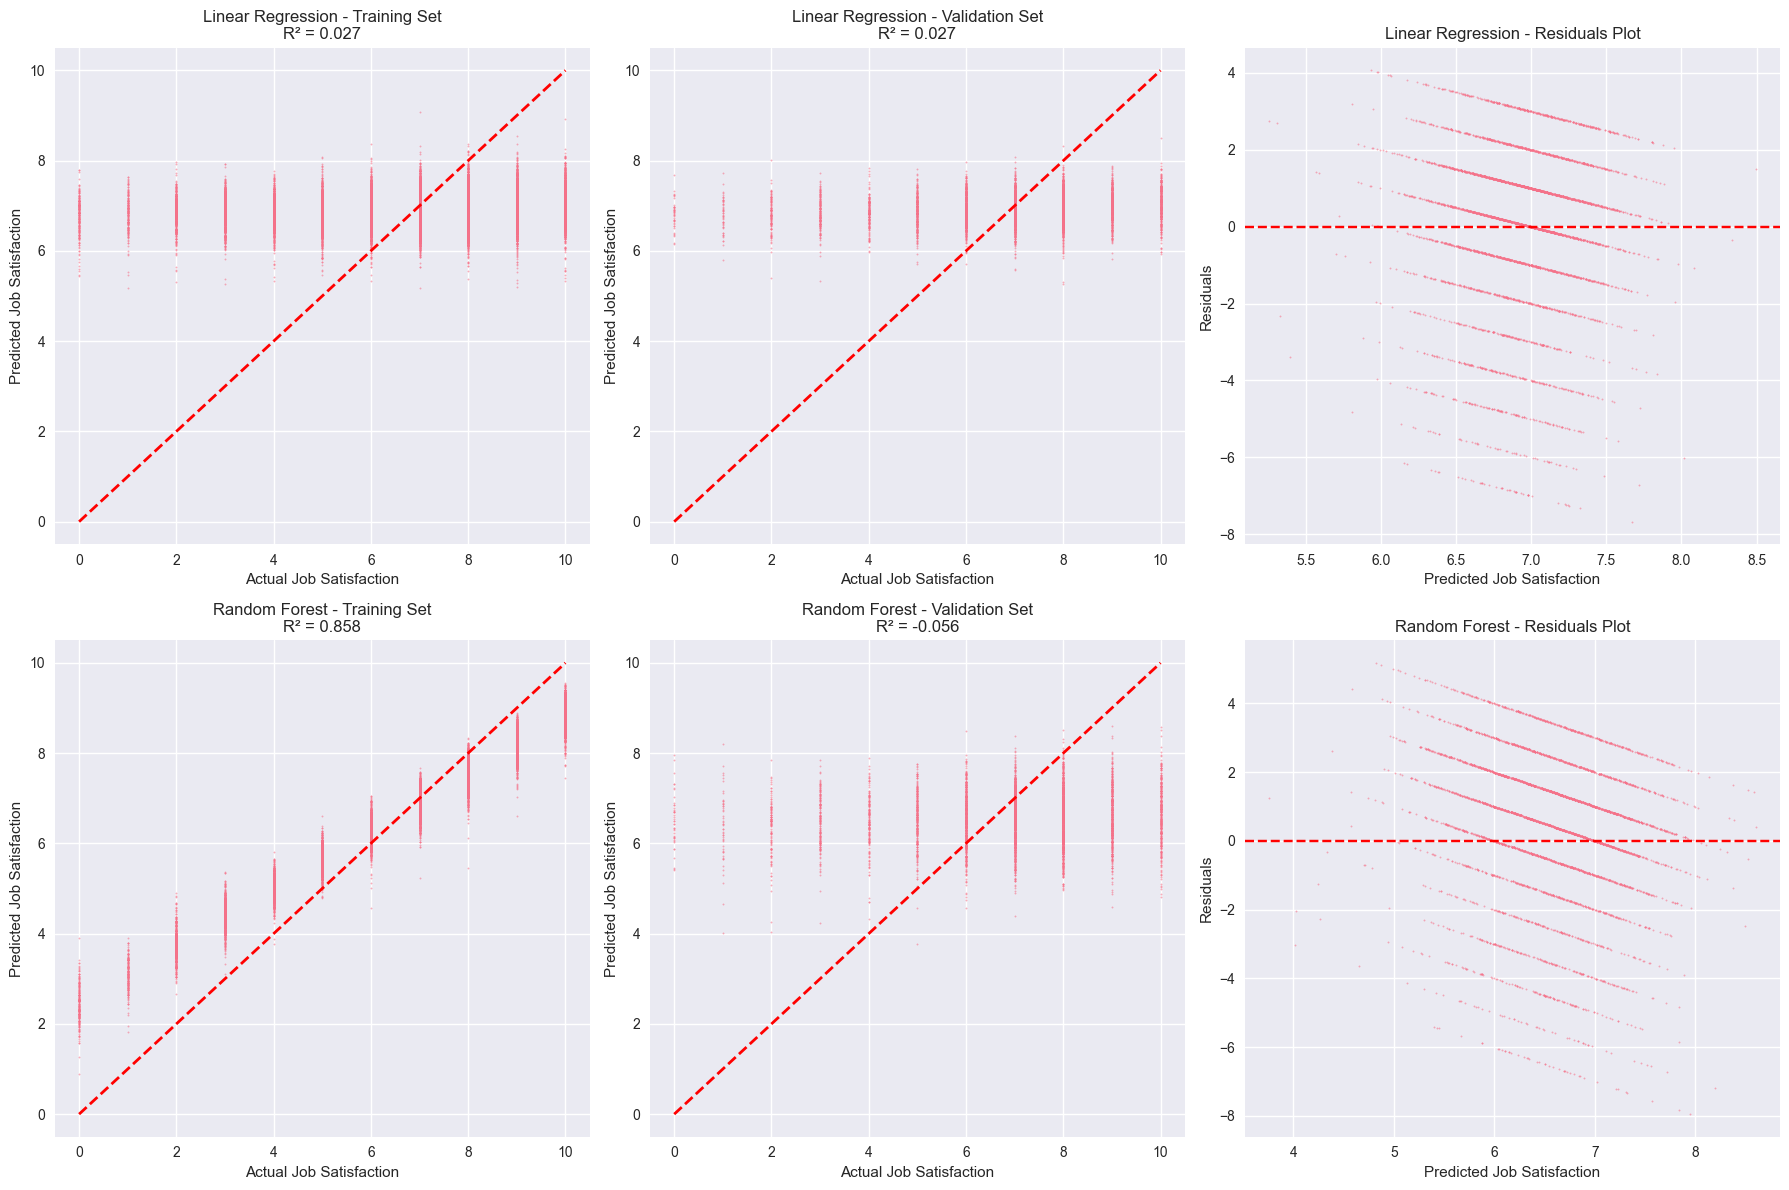

📊 Regression Model Comparison:
               Model  Train_RMSE  Val_RMSE  Train_R2    Val_R2
0  Linear Regression    2.061500  2.087762  0.027056  0.027091
1      Random Forest    0.787966  2.174965  0.857853 -0.055880

CLASSIFICATION EVALUATION


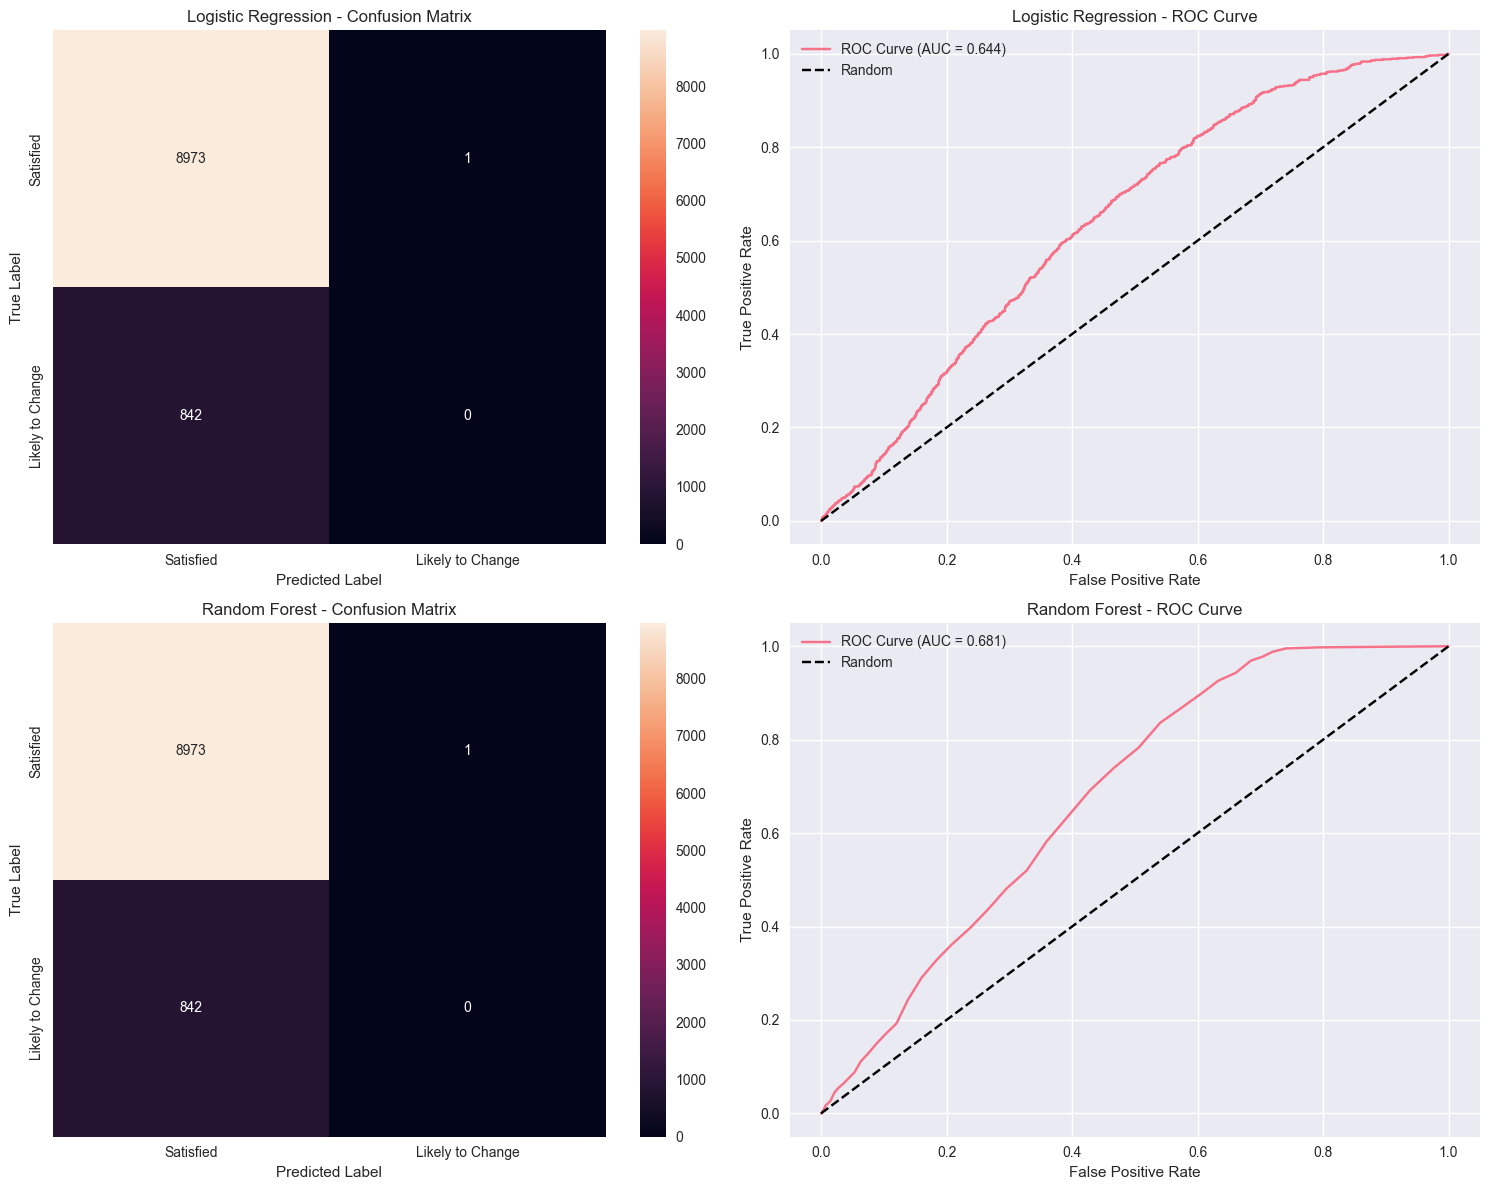

Classification Model Comparison:
                 Model  Train_Accuracy  Val_Accuracy  Train_F1  Val_F1  \
0  Logistic Regression        0.914245       0.91412       0.0     0.0   
1        Random Forest        1.000000       0.91412       1.0     0.0   

   Val_ROC_AUC  
0     0.643534  
1     0.681272  
Classification Reports:

Logistic Regression:
                  precision    recall  f1-score   support

       Satisfied       0.91      1.00      0.96      8974
Likely to Change       0.00      0.00      0.00       842

        accuracy                           0.91      9816
       macro avg       0.46      0.50      0.48      9816
    weighted avg       0.84      0.91      0.87      9816

Prediction distribution:
Satisfied (0): 9,815
Likely to Change (1): 1

Random Forest:
                  precision    recall  f1-score   support

       Satisfied       0.91      1.00      0.96      8974
Likely to Change       0.00      0.00      0.00       842

        accuracy                  

In [ ]:
def create_evaluation_plots(models, results, y_train, y_val, task_type='regression'):    
    if task_type == 'regression':
        # Regression evaluation plots
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))
        
        for i, (name, result) in enumerate(results.items()):
            row = i
            
            # Predicted vs Actual (Training)
            axes[row, 0].scatter(y_train, result['train_pred'], alpha=0.5, s=1)
            axes[row, 0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', lw=2)
            axes[row, 0].set_xlabel('Actual Job Satisfaction')
            axes[row, 0].set_ylabel('Predicted Job Satisfaction')
            axes[row, 0].set_title(f'{name} - Training Set\nR² = {result["train_r2"]:.3f}')
            
            # Predicted vs Actual (Validation)
            axes[row, 1].scatter(y_val, result['val_pred'], alpha=0.5, s=1)
            axes[row, 1].plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--', lw=2)
            axes[row, 1].set_xlabel('Actual Job Satisfaction')
            axes[row, 1].set_ylabel('Predicted Job Satisfaction')
            axes[row, 1].set_title(f'{name} - Validation Set\nR² = {result["val_r2"]:.3f}')
            
            # Residuals plot
            residuals = y_val.values - result['val_pred']
            axes[row, 2].scatter(result['val_pred'], residuals, alpha=0.5, s=1)
            axes[row, 2].axhline(y=0, color='r', linestyle='--')
            axes[row, 2].set_xlabel('Predicted Job Satisfaction')
            axes[row, 2].set_ylabel('Residuals')
            axes[row, 2].set_title(f'{name} - Residuals Plot')
        
        plt.tight_layout()
        plt.show()
        
        # Model comparison
        comparison_data = []
        for name, result in results.items():
            comparison_data.append({
                'Model': name,
                'Train_RMSE': result['train_rmse'],
                'Val_RMSE': result['val_rmse'],
                'Train_R2': result['train_r2'],
                'Val_R2': result['val_r2']
            })
        
        comparison_df = pd.DataFrame(comparison_data)
        print("Regression Model Comparison:")
        print(comparison_df)
        
    else:
        # Classification evaluation plots
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        
        for i, (name, result) in enumerate(results.items()):
            row = i
            
            # Confusion Matrix
            cm = confusion_matrix(y_val, result['val_pred'])
            sns.heatmap(cm, annot=True, fmt='d', ax=axes[row, 0], 
                       xticklabels=['Satisfied', 'Likely to Change'],
                       yticklabels=['Satisfied', 'Likely to Change'])
            axes[row, 0].set_title(f'{name} - Confusion Matrix')
            axes[row, 0].set_ylabel('True Label')
            axes[row, 0].set_xlabel('Predicted Label')
            
            # ROC Curve
            from sklearn.metrics import roc_curve
            fpr, tpr, _ = roc_curve(y_val, result['val_pred_proba'])
            axes[row, 1].plot(fpr, tpr, label=f'ROC Curve (AUC = {result["val_roc_auc"]:.3f})')
            axes[row, 1].plot([0, 1], [0, 1], 'k--', label='Random')
            axes[row, 1].set_xlabel('False Positive Rate')
            axes[row, 1].set_ylabel('True Positive Rate')
            axes[row, 1].set_title(f'{name} - ROC Curve')
            axes[row, 1].legend()
            axes[row, 1].grid(True)
        
        plt.tight_layout()
        plt.show()
        
        # Model comparison
        comparison_data = []
        for name, result in results.items():
            comparison_data.append({
                'Model': name,
                'Train_Accuracy': result['train_accuracy'],
                'Val_Accuracy': result['val_accuracy'],
                'Train_F1': result['train_f1'],
                'Val_F1': result['val_f1'],
                'Val_ROC_AUC': result['val_roc_auc']
            })
        
        comparison_df = pd.DataFrame(comparison_data)
        print("Classification Model Comparison:")
        print(comparison_df)

print("REGRESSION EVALUATION")
create_evaluation_plots(reg_models, reg_results, y_reg_train, y_reg_val, 'regression')

print("\n" + "="*60)

print("CLASSIFICATION EVALUATION")
create_evaluation_plots(class_models, class_results, y_class_train, y_class_val, 'classification')

print(f"Classification Reports:")
for name, result in class_results.items():
    print(f"\n{name}:")
    print(classification_report(y_class_val, result['val_pred'], 
                              target_names=['Satisfied', 'Likely to Change']))
    
    # Class distribution in predictions
    pred_dist = pd.Series(result['val_pred']).value_counts()
    print(f"Prediction distribution:")
    print(f"Satisfied (0): {pred_dist.get(0, 0):,}")
    print(f"Likely to Change (1): {pred_dist.get(1, 0):,}")

## Model Interpretation

REGRESSION MODEL INTERPRETATION
Interpreting Linear Regression...
   Top 10 most influential features (by absolute coefficient):
      ExperienceLevel_Beginner: -0.6356 ↓
      RemoteWork_nan: 0.6090 ↑
      RemoteWork_In-person: -0.4021 ↓
      OrgSize_Just me - I am a freelancer, sole proprietor, etc.: 0.3844 ↑
      ExperienceLevel_Senior: 0.3715 ↑
      OrgSize_nan: -0.3215 ↓
      ExperienceLevel_Mid-level: 0.3154 ↑
      OrgSize_I don’t know: -0.2911 ↓
      EdLevel_Something else: -0.2911 ↓
      OrgSize_2 to 9 employees: 0.2837 ↑
Interpreting Random Forest...
   Top 10 most important features:
      LanguageHaveWorkedWith: 0.1173
      DatabaseHaveWorkedWith: 0.0918
      ConvertedCompYearly: 0.0708
      Country: 0.0629
      PlatformHaveWorkedWith: 0.0627
      YearsCodePro: 0.0625
      DevType: 0.0595
      TechDiversityScore: 0.0533
      LanguageCount: 0.0457
      YearsCode: 0.0390


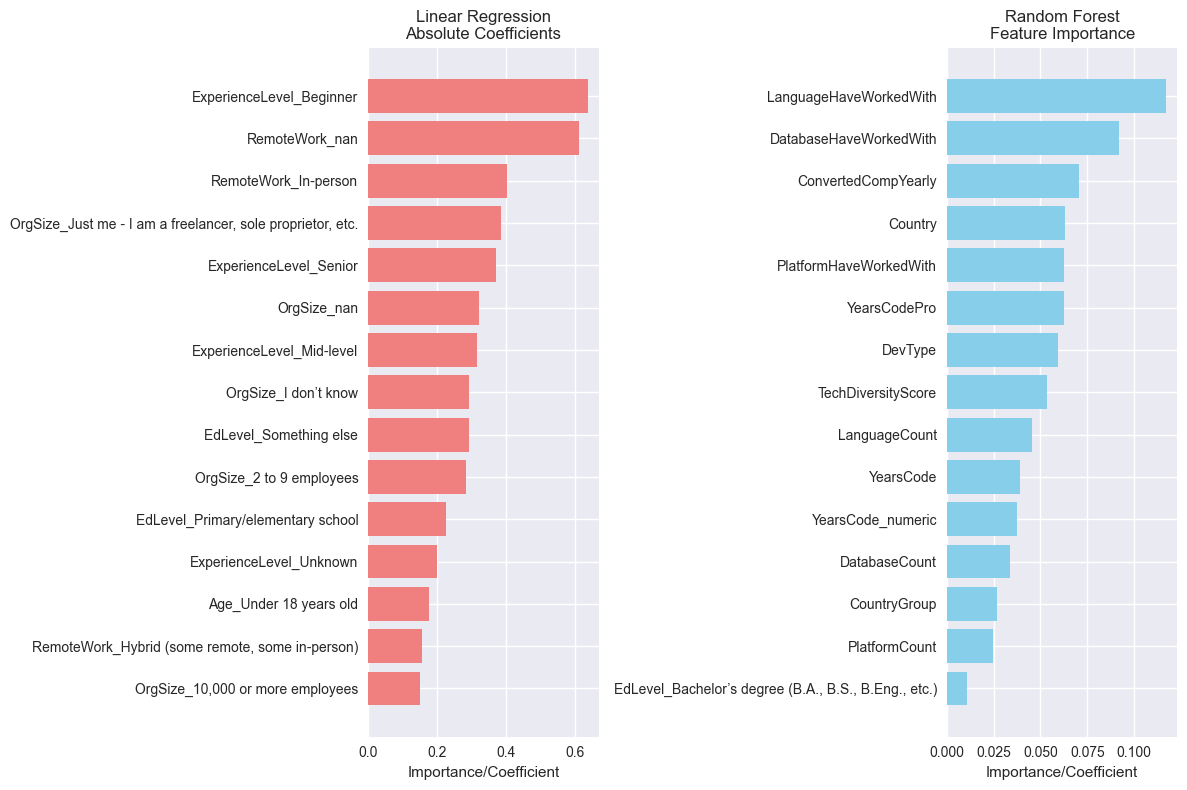


CLASSIFICATION MODEL INTERPRETATION
Interpreting Logistic Regression...
   Top 10 most influential features (by absolute coefficient):
      CompensationCategory_Unknown: -0.2087 ↓
      OrgSize_nan: -0.2081 ↓
      RemoteWork_nan: -0.1702 ↓
      CountryGroup: -0.1299 ↓
      AgeGroup_Under 25: -0.0879 ↓
      RemoteWork_In-person: 0.0871 ↑
      CompensationCategory_Low: 0.0677 ↑
      PlatformCount: -0.0638 ↓
      EdLevel_Bachelor’s degree (B.A., B.S., B.Eng., etc.): 0.0576 ↑
      YearsCodePro: -0.0570 ↓
Interpreting Random Forest...
   Top 10 most important features:
      LanguageHaveWorkedWith: 0.0854
      DatabaseHaveWorkedWith: 0.0719
      TechDiversityScore: 0.0581
      Country: 0.0573
      YearsCodePro: 0.0558
      PlatformHaveWorkedWith: 0.0547
      DevType: 0.0544
      YearsCode: 0.0514
      LanguageCount: 0.0502
      YearsCode_numeric: 0.0498


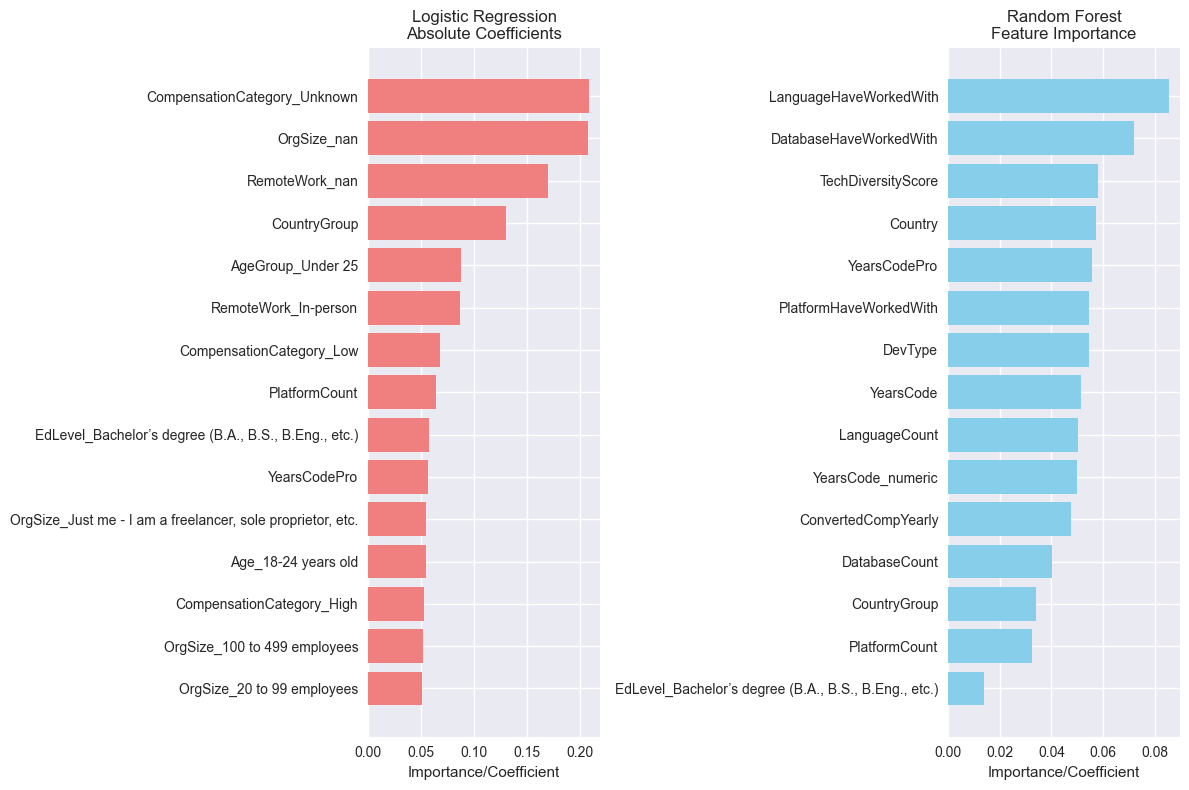

Job Satisfaction Drivers (Regression):
   Top factors influencing job satisfaction:
   • LanguageHaveWorkedWith: 0.117
   • DatabaseHaveWorkedWith: 0.092
   • ConvertedCompYearly: 0.071
   • Country: 0.063
   • PlatformHaveWorkedWith: 0.063

🚪 Job Change Predictors (Classification):
   Top factors predicting job change intent:
   • LanguageHaveWorkedWith: 0.085
   • DatabaseHaveWorkedWith: 0.072
   • TechDiversityScore: 0.058
   • Country: 0.057
   • YearsCodePro: 0.056

   Logistic Regression insights (coefficient direction):
   • CompensationCategory_Unknown: decreases likelihood of job change
   • OrgSize_nan: decreases likelihood of job change
   • RemoteWork_nan: decreases likelihood of job change
   • CountryGroup: decreases likelihood of job change
   • AgeGroup_Under 25: decreases likelihood of job change


In [43]:
def interpret_models(models, X_train_enc, feature_names=None):
    """Extract and visualize feature importance from trained models"""
    
    if feature_names is None:
        feature_names = X_train_enc.columns.tolist()
    
    interpretations = {}
    
    for name, model in models.items():
        print(f"Interpreting {name}...")
        
        if hasattr(model, 'feature_importances_'):
            # Tree-based models (Random Forest)
            importances = model.feature_importances_
            feature_importance = pd.DataFrame({
                'feature': feature_names,
                'importance': importances
            }).sort_values('importance', ascending=False)
            
            print(f"   Top 10 most important features:")
            for idx, row in feature_importance.head(10).iterrows():
                print(f"      {row['feature']}: {row['importance']:.4f}")
            
            interpretations[name] = feature_importance
            
        elif hasattr(model, 'coef_'):
            # Linear models (Linear/Logistic Regression)
            if len(model.coef_.shape) == 1:  # Binary classification
                coefficients = model.coef_
            else:  # Multi-class or regression
                coefficients = model.coef_[0] if len(model.coef_.shape) > 1 else model.coef_
            
            feature_importance = pd.DataFrame({
                'feature': feature_names,
                'coefficient': coefficients,
                'abs_coefficient': np.abs(coefficients)
            }).sort_values('abs_coefficient', ascending=False)
            
            print(f"   Top 10 most influential features (by absolute coefficient):")
            for idx, row in feature_importance.head(10).iterrows():
                direction = "↑" if row['coefficient'] > 0 else "↓"
                print(f"      {row['feature']}: {row['coefficient']:.4f} {direction}")
            
            interpretations[name] = feature_importance
    
    return interpretations

def plot_feature_importance(interpretations, max_features=15):
    """Plot feature importance for all models"""
    
    n_models = len(interpretations)
    fig, axes = plt.subplots(1, n_models, figsize=(6*n_models, 8))
    
    if n_models == 1:
        axes = [axes]
    
    for i, (name, importance_df) in enumerate(interpretations.items()):
        # Get top features
        top_features = importance_df.head(max_features)
        
        if 'importance' in importance_df.columns:
            # Tree-based model
            y_values = top_features['importance']
            title = f'{name}\nFeature Importance'
            color = 'skyblue'
        else:
            # Linear model
            y_values = top_features['abs_coefficient']
            title = f'{name}\nAbsolute Coefficients'
            color = 'lightcoral'
        
        # Create horizontal bar plot
        axes[i].barh(range(len(top_features)), y_values, color=color)
        axes[i].set_yticks(range(len(top_features)))
        axes[i].set_yticklabels(top_features['feature'], fontsize=10)
        axes[i].set_xlabel('Importance/Coefficient')
        axes[i].set_title(title)
        axes[i].invert_yaxis()
    
    plt.tight_layout()
    plt.show()

# Interpret regression models
print("REGRESSION MODEL INTERPRETATION")
reg_interpretations = interpret_models(reg_models, X_reg_train_enc)
plot_feature_importance(reg_interpretations)

print("\n" + "="*60)

# Interpret classification models
print("CLASSIFICATION MODEL INTERPRETATION")
class_interpretations = interpret_models(class_models, X_class_train_enc)
plot_feature_importance(class_interpretations)

print(f"Job Satisfaction Drivers (Regression):")
if 'Random Forest' in reg_interpretations:
    rf_reg_features = reg_interpretations['Random Forest'].head(5)
    print("   Top factors influencing job satisfaction:")
    for idx, row in rf_reg_features.iterrows():
        print(f"   • {row['feature']}: {row['importance']:.3f}")

print(f"\n🚪 Job Change Predictors (Classification):")
if 'Random Forest' in class_interpretations:
    rf_class_features = class_interpretations['Random Forest'].head(5)
    print("   Top factors predicting job change intent:")
    for idx, row in rf_class_features.iterrows():
        print(f"   • {row['feature']}: {row['importance']:.3f}")

if 'Logistic Regression' in class_interpretations:
    lr_features = class_interpretations['Logistic Regression'].head(5)
    print(f"\n   Logistic Regression insights (coefficient direction):")
    for idx, row in lr_features.iterrows():
        direction = "increases" if row['coefficient'] > 0 else "decreases"
        print(f"   • {row['feature']}: {direction} likelihood of job change")

In [44]:
def handle_class_imbalance(X_train, y_train, X_val, y_val, technique='smote'):
    """Apply various class imbalance handling techniques"""
    
    print(f"Applying {technique.upper()} for class imbalance...")
    print(f"Original distribution: {dict(y_train.value_counts().sort_index())}")
    
    if technique == 'smote':
        # SMOTE (Synthetic Minority Oversampling Technique)
        sampler = SMOTE(random_state=42, k_neighbors=5)
        
    elif technique == 'adasyn':
        # ADASYN (Adaptive Synthetic Sampling)
        sampler = ADASYN(random_state=42, n_neighbors=5)
        
    elif technique == 'smote_tomek':
        # SMOTE + Tomek links (hybrid approach)
        sampler = SMOTETomek(random_state=42)
        
    elif technique == 'smote_enn':
        # SMOTE + Edited Nearest Neighbours
        sampler = SMOTEENN(random_state=42)
        
    elif technique == 'undersample':
        # Random undersampling
        sampler = RandomUnderSampler(random_state=42)
        
    else:
        print(f"   Unknown technique: {technique}")
        return X_train, y_train, X_val, y_val
    
    # Apply resampling
    try:
        X_train_resampled, y_train_resampled = sampler.fit_resample(X_train, y_train)
        
        print(f"   Resampled distribution: {dict(pd.Series(y_train_resampled).value_counts().sort_index())}")
        print(f"   Training set size: {len(X_train)} → {len(X_train_resampled)}")
        
        return X_train_resampled, y_train_resampled, X_val, y_val
        
    except Exception as e:
        print(f"Resampling failed: {str(e)}")
        return X_train, y_train, X_val, y_val

# Test different resampling techniques
print("Testing Multiple Resampling Techniques:")
print("="*50)

resampling_techniques = ['smote', 'adasyn', 'smote_tomek', 'undersample']
resampled_datasets = {}

for technique in resampling_techniques:
    X_train_res, y_train_res, X_val_res, y_val_res = handle_class_imbalance(
        X_class_train_enc, y_class_train, X_class_val_enc, y_class_val, technique
    )
    
    resampled_datasets[technique] = {
        'X_train': X_train_res,
        'y_train': y_train_res,
        'X_val': X_val_res,
        'y_val': y_val_res
    }
    print()

print("Class imbalance handling completed!")
print(f"Available resampled datasets: {list(resampled_datasets.keys())}")

Testing Multiple Resampling Techniques:
Applying SMOTE for class imbalance...
Original distribution: {0: 41878, 1: 3927}


OMP: Warning #179: Function Can't set size of /tmp file failed:


   Resampled distribution: {0: 41878, 1: 41878}
   Training set size: 45805 → 83756

Applying ADASYN for class imbalance...
Original distribution: {0: 41878, 1: 3927}
   Resampled distribution: {0: 41878, 1: 42563}
   Training set size: 45805 → 84441

Applying SMOTE_TOMEK for class imbalance...
Original distribution: {0: 41878, 1: 3927}
   Resampled distribution: {0: 41878, 1: 42563}
   Training set size: 45805 → 84441

Applying SMOTE_TOMEK for class imbalance...
Original distribution: {0: 41878, 1: 3927}
   Resampled distribution: {0: 40530, 1: 40530}
   Training set size: 45805 → 81060

Applying UNDERSAMPLE for class imbalance...
Original distribution: {0: 41878, 1: 3927}
   Resampled distribution: {0: 3927, 1: 3927}
   Training set size: 45805 → 7854

Class imbalance handling completed!
Available resampled datasets: ['smote', 'adasyn', 'smote_tomek', 'undersample']
   Resampled distribution: {0: 40530, 1: 40530}
   Training set size: 45805 → 81060

Applying UNDERSAMPLE for class imb

In [45]:
@cache_results("advanced_gradient_boosting", force_refresh=True)
@time_operation("Advanced Gradient Boosting Training")
def train_advanced_gradient_boosting():
    
    def clean_feature_names(df):
        """Clean column names for LightGBM compatibility"""
        new_columns = []
        for col in df.columns:
            # Replace special characters with underscores
            new_col = re.sub(r'[^\w]', '_', str(col))
            # Remove consecutive underscores
            new_col = re.sub(r'_+', '_', new_col)
            # Remove leading/trailing underscores
            new_col = new_col.strip('_')
            # Ensure it doesn't start with a number
            if new_col and new_col[0].isdigit():
                new_col = 'col_' + new_col
            # Ensure it's not empty
            if not new_col:
                new_col = f'col_{len(new_columns)}'
            new_columns.append(new_col)
        
        final_columns = []
        for col in new_columns:
            original = col
            counter = 1
            while col in final_columns:
                col = f"{original}_{counter}"
                counter += 1
            final_columns.append(col)
        
        return df.rename(columns=dict(zip(df.columns, final_columns)))
    
    results = {}
    
    try:
        X_train = clean_feature_names(class_feature_selection['tree']['X_train'])
        X_val = clean_feature_names(class_feature_selection['tree']['X_val'])
        y_train = y_class_train
        y_val = y_class_val
        print(f"Using optimized feature set: {X_train.shape[1]} features")
    except:
        X_train = clean_feature_names(X_class_train_enc)
        X_val = clean_feature_names(X_class_val_enc)
        y_train = y_class_train
        y_val = y_class_val
        print(f"Using encoded feature set: {X_train.shape[1]} features")
    
    print(f"Training data: {X_train.shape}")
    print(f"Validation data: {X_val.shape}")

    # Apply SMOTE for balanced training
    smote = SMOTE(random_state=42)
    X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)
    print(f"Applied SMOTE: {X_train_balanced.shape[0]:,} balanced samples")

    # Train XGBoost
    print("Training XGBoost...")
    try:
        xgb_params = {
            'n_estimators': 500,
            'learning_rate': 0.1,
            'max_depth': 8,
            'min_child_weight': 3,
            'subsample': 0.8,
            'colsample_bytree': 0.8,
            'gamma': 0.1,
            'reg_alpha': 0.1,
            'reg_lambda': 1.0,
            'random_state': 42,
            'n_jobs': -1,
            'eval_metric': 'logloss'
        }
        
        xgb_model = XGBClassifier(**xgb_params)
        xgb_model.fit(X_train_balanced, y_train_balanced)

        xgb_pred_proba = xgb_model.predict_proba(X_val)[:, 1]
        xgb_pred = (xgb_pred_proba > 0.5).astype(int)
        
        results['XGBoost'] = {
            'model': xgb_model,
            'accuracy': accuracy_score(y_val, xgb_pred),
            'precision': precision_score(y_val, xgb_pred, average='weighted'),
            'recall': recall_score(y_val, xgb_pred, average='weighted'),
            'f1': f1_score(y_val, xgb_pred, average='weighted'),
            'roc_auc': roc_auc_score(y_val, xgb_pred_proba),
            'feature_importance': dict(zip(X_train.columns, xgb_model.feature_importances_))
        }
        
        print(f"XGBoost: AUC={results['XGBoost']['roc_auc']:.4f}, F1={results['XGBoost']['f1']:.4f}")
        
    except Exception as e:
        print(f"XGBoost failed: {e}")    

    # Train LightGBM
    print("Training LightGBM...")
    try:
        lgbm_params = {
            'n_estimators': 500,
            'learning_rate': 0.1,
            'max_depth': -1,
            'num_leaves': 127,
            'min_child_samples': 20,
            'subsample': 0.8,
            'colsample_bytree': 0.8,
            'reg_alpha': 0.1,
            'reg_lambda': 0.1,
            'random_state': 42,
            'n_jobs': -1,
            'verbose': -1
        }
        
        lgbm_model = LGBMClassifier(**lgbm_params)
        lgbm_model.fit(X_train_balanced, y_train_balanced)
    
        lgbm_pred_proba = lgbm_model.predict_proba(X_val)[:, 1]
        lgbm_pred = (lgbm_pred_proba > 0.5).astype(int)
        
        results['LightGBM'] = {
            'model': lgbm_model,
            'accuracy': accuracy_score(y_val, lgbm_pred),
            'precision': precision_score(y_val, lgbm_pred, average='weighted'),
            'recall': recall_score(y_val, lgbm_pred, average='weighted'),
            'f1': f1_score(y_val, lgbm_pred, average='weighted'),
            'roc_auc': roc_auc_score(y_val, lgbm_pred_proba),
            'feature_importance': dict(zip(X_train.columns, lgbm_model.feature_importances_))
        }
        
        print(f"LightGBM: AUC={results['LightGBM']['roc_auc']:.4f}, F1={results['LightGBM']['f1']:.4f}")
        
    except Exception as e:
        print(f"LightGBM failed: {e}")
    
    # Train CatBoost
    print("Training CatBoost...")
    try:
        catb_params = {
            'iterations': 500,
            'learning_rate': 0.1,
            'depth': 8,
            'l2_leaf_reg': 3,
            'bootstrap_type': 'Bernoulli',
            'subsample': 0.8,
            'random_seed': 42,
            'verbose': False,
            'early_stopping_rounds': 50
        }
        
        catb_model = CatBoostClassifier(**catb_params)
        catb_model.fit(
            X_train_balanced, y_train_balanced,
            eval_set=(X_val, y_val)
        )
        
        # Predictions
        catb_pred_proba = catb_model.predict_proba(X_val)[:, 1]
        catb_pred = (catb_pred_proba > 0.5).astype(int)
        
        results['CatBoost'] = {
            'model': catb_model,
            'accuracy': accuracy_score(y_val, catb_pred),
            'precision': precision_score(y_val, catb_pred, average='weighted'),
            'recall': recall_score(y_val, catb_pred, average='weighted'),
            'f1': f1_score(y_val, catb_pred, average='weighted'),
            'roc_auc': roc_auc_score(y_val, catb_pred_proba),
            'feature_importance': dict(zip(X_train.columns, catb_model.feature_importances_))
        }
        
        print(f"CatBoost: AUC={results['CatBoost']['roc_auc']:.4f}, F1={results['CatBoost']['f1']:.4f}")
        
    except Exception as e:
        print(f"CatBoost failed: {e}")

    return results

In [46]:
print("Training Advanced Gradient Boosting Models...")
advanced_gb_results = train_advanced_gradient_boosting()

print("\n" + "="*80)
print("ADVANCED MODEL RESULTS SUMMARY")
print("="*80)

for model_name, results in advanced_gb_results.items():
    print(f"\n🔸 {model_name}:")
    print(f"   Accuracy:  {results['accuracy']:.4f}")
    print(f"   Precision: {results['precision']:.4f}")
    print(f"   Recall:    {results['recall']:.4f}")
    print(f"   F1-Score:  {results['f1']:.4f}")
    print(f"   ROC-AUC:   {results['roc_auc']:.4f}")

# Identify best performing advanced model
best_model = max(advanced_gb_results.items(), key=lambda x: x[1]['roc_auc'])
print(f"Best Advanced Model: {best_model[0]} (ROC-AUC: {best_model[1]['roc_auc']:.4f})")

print("\Advanced gradient boosting training complete!")

Training Advanced Gradient Boosting Models...
Computing train_advanced_gradient_boosting (this may take a while...)

==================== Advanced Gradient Boosting Training ====================
Using encoded feature set: 62 features
Training data: (45805, 62)
Validation data: (9816, 62)
Applied SMOTE: 83,756 balanced samples
Training XGBoost...
XGBoost: AUC=0.6838, F1=0.8732
Training LightGBM...
XGBoost: AUC=0.6838, F1=0.8732
Training LightGBM...
LightGBM: AUC=0.6790, F1=0.8730
Training CatBoost...
CatBoost failed: (Error 28: No space left on device) util/system/file.cpp:936: can't open "catboost_info/tmp/cat_feature_index.7a4b64f0-f0a48aee-8f685d60-e91c0618.tmp" with mode RdWr|CreateAlways (0x0000001C)
✅ Advanced Gradient Boosting Training completed in 19.64 seconds

Cache write error: [Errno 28] No space left on device: 'ml_cache/advanced_gradient_boosting.pkl'

ADVANCED MODEL RESULTS SUMMARY

🔸 XGBoost:
   Accuracy:  0.9118
   Precision: 0.8504
   Recall:    0.9118
   F1-Score:  0.

In [51]:
@cache_results("neural_networks", force_refresh=False)
@time_operation("Neural Network Training")
def train_neural_networks():
    """Train various neural network architectures"""
    
    results = {}
    
    # Prepare data for neural networks
    try:
        X_train = X_class_train_enc
        X_val = X_class_val_enc
        y_train = y_class_train
        y_val = y_class_val
        print(f"Using encoded features: {X_train.shape[1]} features")
    except:
        print("Error: Encoded features not found. Neural network training skipped.")
        return {}
    
    # Apply SMOTE for balanced training
    smote = SMOTE(random_state=42)
    X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)
    print(f"Applied SMOTE: {X_train_balanced.shape[0]:,} balanced samples")
    
    # Scale the data for neural networks
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_balanced)
    X_val_scaled = scaler.transform(X_val)
    
    # Simple Neural Network
    print("Training Simple Neural Network...")
    try:
        model_simple = keras.Sequential([
            layers.Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
            layers.Dropout(0.3),
            layers.Dense(32, activation='relu'),
            layers.Dropout(0.3),
            layers.Dense(1, activation='sigmoid')
        ])
        
        model_simple.compile(
            optimizer='adam',
            loss='binary_crossentropy',
            metrics=['accuracy', 'AUC']
        )
        
        # Early stopping
        early_stop = callbacks.EarlyStopping(
            monitor='val_auc',
            patience=10,
            restore_best_weights=True,
            mode='max'
        )
        
        history_simple = model_simple.fit(
            X_train_scaled, y_train_balanced,
            validation_data=(X_val_scaled, y_val),
            epochs=100,
            batch_size=32,
            callbacks=[early_stop],
            verbose=0
        )
        
        # Predictions
        y_pred_proba = model_simple.predict(X_val_scaled, verbose=0).flatten()
        y_pred = (y_pred_proba > 0.5).astype(int)
        
        results['Simple_NN'] = {
            'model': model_simple,
            'accuracy': accuracy_score(y_val, y_pred),
            'precision': precision_score(y_val, y_pred, average='weighted'),
            'recall': recall_score(y_val, y_pred, average='weighted'),
            'f1': f1_score(y_val, y_pred, average='weighted'),
            'roc_auc': roc_auc_score(y_val, y_pred_proba),
            'history': history_simple.history,
            'probabilities': y_pred_proba
        }
        
        print(f"Simple NN: AUC={results['Simple_NN']['roc_auc']:.4f}, F1={results['Simple_NN']['f1']:.4f}")
        
    except Exception as e:
        print(f"Simple NN failed: {e}")
    
    # Deep Neural Network
    print("Training Deep Neural Network...")
    try:
        model_deep = keras.Sequential([
            layers.Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)),
            layers.BatchNormalization(),
            layers.Dropout(0.3),
            layers.Dense(64, activation='relu'),
            layers.BatchNormalization(),
            layers.Dropout(0.3),
            layers.Dense(32, activation='relu'),
            layers.Dropout(0.2),
            layers.Dense(16, activation='relu'),
            layers.Dense(1, activation='sigmoid')
        ])
        
        model_deep.compile(
            optimizer=optimizers.Adam(learning_rate=0.001),
            loss='binary_crossentropy',
            metrics=['accuracy', 'AUC']
        )
        
        history_deep = model_deep.fit(
            X_train_scaled, y_train_balanced,
            validation_data=(X_val_scaled, y_val),
            epochs=100,
            batch_size=32,
            callbacks=[early_stop],
            verbose=0
        )
        
        # Predictions
        y_pred_proba_deep = model_deep.predict(X_val_scaled, verbose=0).flatten()
        y_pred_deep = (y_pred_proba_deep > 0.5).astype(int)
        
        results['Deep_NN'] = {
            'model': model_deep,
            'accuracy': accuracy_score(y_val, y_pred_deep),
            'precision': precision_score(y_val, y_pred_deep, average='weighted'),
            'recall': recall_score(y_val, y_pred_deep, average='weighted'),
            'f1': f1_score(y_val, y_pred_deep, average='weighted'),
            'roc_auc': roc_auc_score(y_val, y_pred_proba_deep),
            'history': history_deep.history,
            'probabilities': y_pred_proba_deep
        }
        
        print(f"Deep NN: AUC={results['Deep_NN']['roc_auc']:.4f}, F1={results['Deep_NN']['f1']:.4f}")
        
    except Exception as e:
        print(f"Deep NN failed: {e}")
    
    return results

# Execute neural network training
print("Training Neural Networks...")
neural_network_results = train_neural_networks()

Training Neural Networks...
Loading cached results for train_neural_networks


In [54]:
@cache_results("ensemble_models", force_refresh=True) 
@time_operation("Ensemble Model Training")
def train_ensemble_models():
    """Train ensemble models combining multiple approaches"""
    
    results = {}
    
    try:
        X_train = X_class_train_enc
        X_val = X_class_val_enc
        y_train = y_class_train
        y_val = y_class_val
        
        # Apply SMOTE
        smote = SMOTE(random_state=42)
        X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)
        
        print("Training Voting Classifier...")
        
        # Create base models
        rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
        
        if 'advanced_gb_results' in globals() and 'XGBoost' in advanced_gb_results:
            xgb_model = XGBClassifier(n_estimators=100, random_state=42, n_jobs=-1)
            base_models = [('rf', rf_model), ('xgb', xgb_model)]
        else:
            base_models = [('rf', rf_model)]
            
        # Voting Classifier
        voting_clf = VotingClassifier(
            estimators=base_models,
            voting='soft'
        )
        
        voting_clf.fit(X_train_balanced, y_train_balanced)
        
        # Predictions
        y_pred_proba = voting_clf.predict_proba(X_val)[:, 1]
        y_pred = voting_clf.predict(X_val)
        
        results['Voting_Classifier'] = {
            'model': voting_clf,
            'accuracy': accuracy_score(y_val, y_pred),
            'precision': precision_score(y_val, y_pred, average='weighted'),
            'recall': recall_score(y_val, y_pred, average='weighted'),
            'f1': f1_score(y_val, y_pred, average='weighted'),
            'roc_auc': roc_auc_score(y_val, y_pred_proba),
            'probabilities': y_pred_proba
        }
        
        print(f"Voting Classifier: AUC={results['Voting_Classifier']['roc_auc']:.4f}")
        
    except Exception as e:
        print(f"Ensemble training failed: {e}")
    
    return results

# Execute ensemble training
print("Training Ensemble Models...")
ensemble_results = train_ensemble_models()

Training Ensemble Models...
Computing train_ensemble_models (this may take a while...)

==================== Ensemble Model Training ====================
Training Voting Classifier...
Voting Classifier: AUC=0.6938
✅ Ensemble Model Training completed in 2.52 seconds

Voting Classifier: AUC=0.6938
✅ Ensemble Model Training completed in 2.52 seconds

Cache write error: [Errno 28] No space left on device
Cache write error: [Errno 28] No space left on device


## Model Evaluation & Comparison

Running Comprehensive Model Comparison...
Comparing 9 models

MODEL PERFORMANCE RANKING
                     Model  Accuracy  Precision  Recall  F1-Score  ROC-AUC Model_Type
Ensemble_Voting_Classifier    0.9141     0.8358  0.9141    0.8732   0.6938   Ensemble
                GB_XGBoost    0.9118     0.8504  0.9118    0.8732   0.6838         GB
                NN_Deep_NN    0.9137     0.8481  0.9137    0.8732   0.6804         NN
               GB_LightGBM    0.9130     0.8466  0.9130    0.8730   0.6790         GB
              NN_Simple_NN    0.9097     0.8438  0.9097    0.8719   0.6711         NN


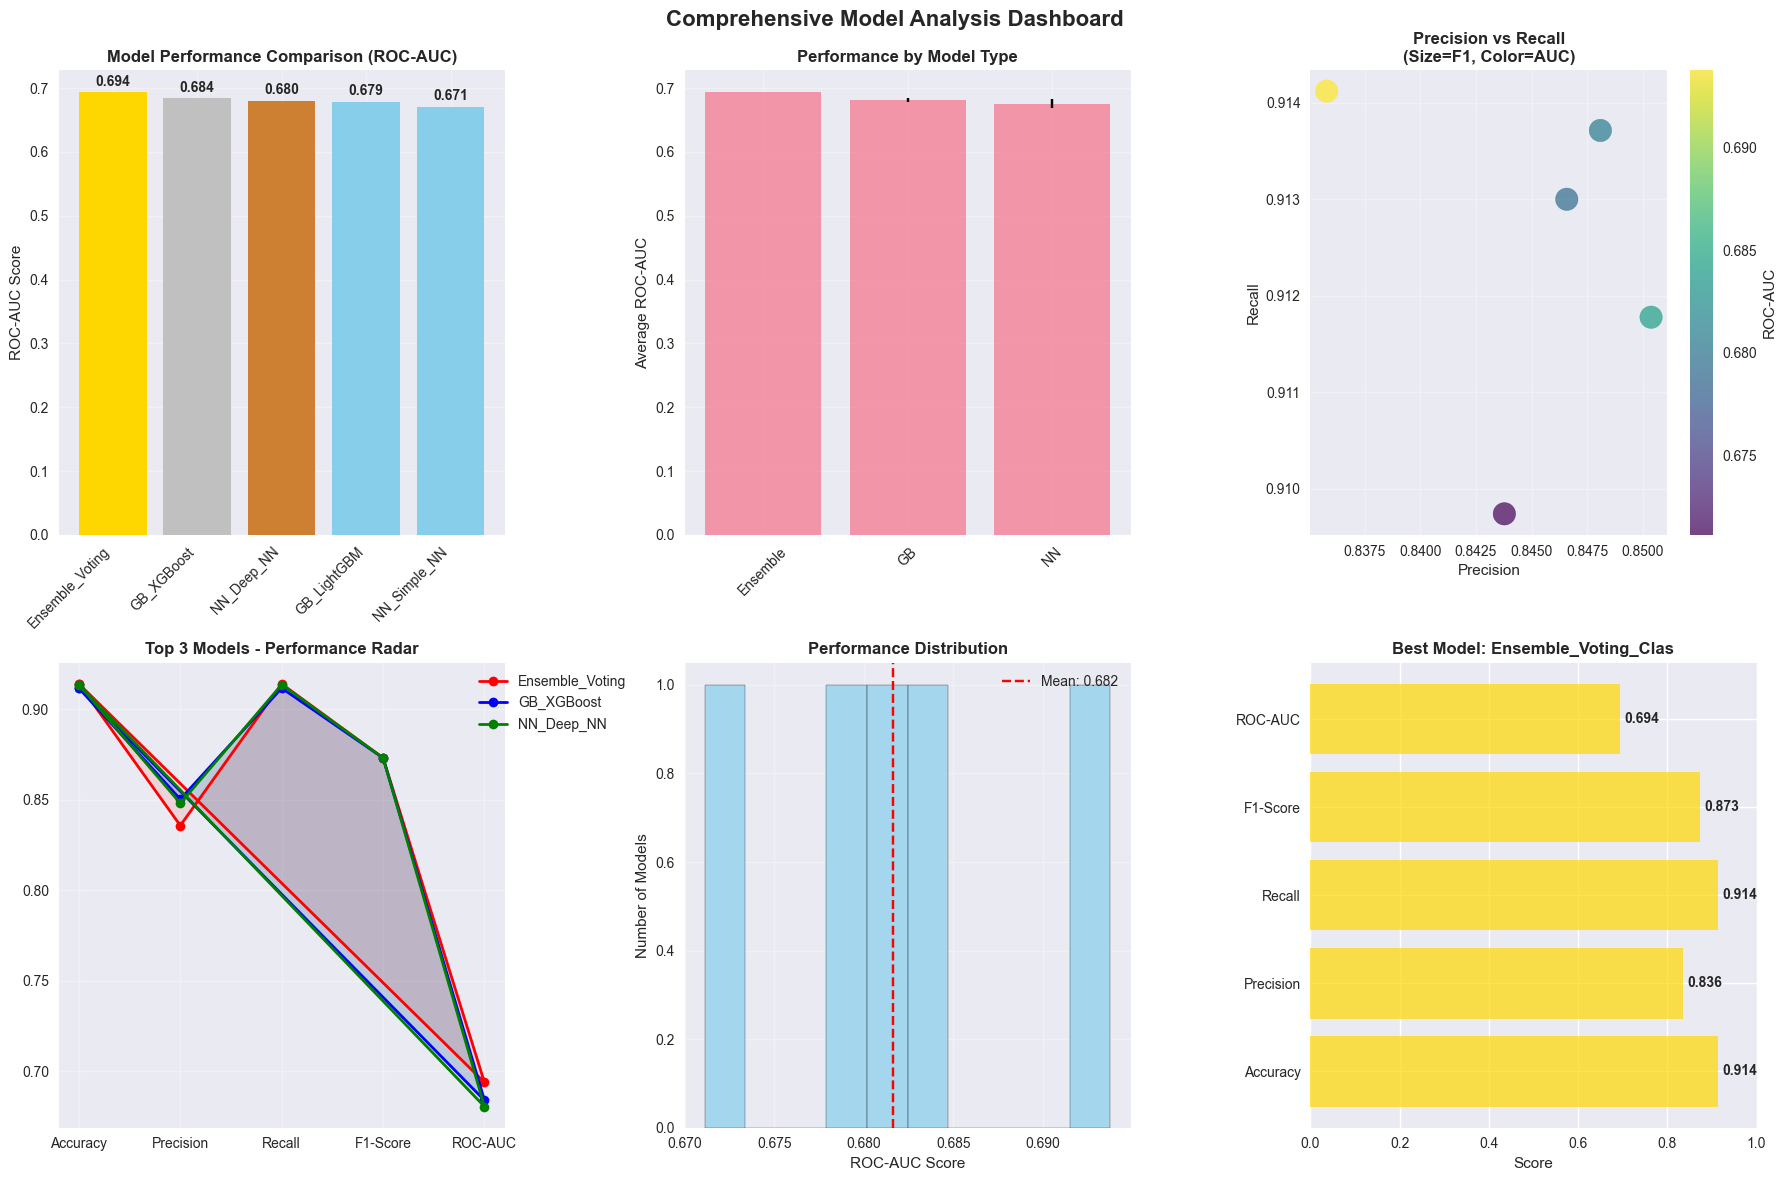

In [55]:
def comprehensive_model_comparison():
    """Compare all trained models with comprehensive metrics"""
    
    # Combine all available model results
    all_results = {}
    
    for name, result in advanced_gb_results.items():
        all_results[f"GB_{name}"] = result

    for name, result in neural_network_results.items():
        all_results[f"NN_{name}"] = result

    for name, result in ensemble_results.items():
        all_results[f"Ensemble_{name}"] = result

    for name, result in class_results.items():
        all_results[f"Baseline_{name}"] = result

    for name, result in reg_results.items():
        all_results[f"Reg_{name}"] = result
    
    print(f"Comparing {len(all_results)} models")
    
    # Create comparison DataFrame
    comparison_data = []
    
    for model_name, metrics in all_results.items():
        if isinstance(metrics, dict) and 'roc_auc' in metrics:
            comparison_data.append({
                'Model': model_name,
                'Accuracy': metrics.get('accuracy', 0),
                'Precision': metrics.get('precision', 0),
                'Recall': metrics.get('recall', 0),
                'F1-Score': metrics.get('f1', 0),
                'ROC-AUC': metrics.get('roc_auc', 0),
                'Model_Type': model_name.split('_')[0]
            })
    
    df_comparison = pd.DataFrame(comparison_data)
    df_comparison = df_comparison.sort_values('ROC-AUC', ascending=False)
    
    print("\n" + "="*80)
    print("MODEL PERFORMANCE RANKING")
    print("="*80)
    print(df_comparison.to_string(index=False, float_format='%.4f'))
    
    # Create visualizations
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    
    # 1. Performance Bar Chart
    ax1 = axes[0, 0]
    top_models = df_comparison.head(8)
    bars = ax1.bar(range(len(top_models)), top_models['ROC-AUC'], 
                   color=['gold', 'silver', '#CD7F32'] + ['skyblue'] * 5)
    ax1.set_title('Model Performance Comparison (ROC-AUC)', fontweight='bold')
    ax1.set_ylabel('ROC-AUC Score')
    ax1.set_xticks(range(len(top_models)))
    ax1.set_xticklabels([name[:15] for name in top_models['Model']], rotation=45, ha='right')
    ax1.grid(True, alpha=0.3)
    
    # Add value labels on bars
    for i, bar in enumerate(bars):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + 0.005,
                f'{height:.3f}', ha='center', va='bottom', fontweight='bold')
    
    # 2. Model Type Performance
    ax2 = axes[0, 1]
    type_performance = df_comparison.groupby('Model_Type')['ROC-AUC'].agg(['mean', 'std']).reset_index()
    bars2 = ax2.bar(type_performance['Model_Type'], type_performance['mean'], 
                    yerr=type_performance['std'], capsize=5, alpha=0.7)
    ax2.set_title('Performance by Model Type', fontweight='bold')
    ax2.set_ylabel('Average ROC-AUC')
    ax2.tick_params(axis='x', rotation=45)
    ax2.grid(True, alpha=0.3)
    
    # 3. Precision vs Recall Scatter
    ax3 = axes[0, 2]
    scatter = ax3.scatter(df_comparison['Precision'], df_comparison['Recall'], 
                         s=df_comparison['F1-Score']*300, 
                         c=df_comparison['ROC-AUC'], 
                         cmap='viridis', alpha=0.7)
    ax3.set_xlabel('Precision')
    ax3.set_ylabel('Recall')
    ax3.set_title('Precision vs Recall\n(Size=F1, Color=AUC)', fontweight='bold')
    plt.colorbar(scatter, ax=ax3, label='ROC-AUC')
    ax3.grid(True, alpha=0.3)
    
    # 4. Top Models Radar Chart
    ax4 = axes[1, 0]
    top_3_models = df_comparison.head(3)
    metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']
    
    angles = np.linspace(0, 2 * np.pi, len(metrics), endpoint=False).tolist()
    angles += angles[:1]
    
    colors = ['red', 'blue', 'green']
    
    for i, (_, row) in enumerate(top_3_models.iterrows()):
        values = [row[metric] for metric in metrics]
        values += values[:1]
        
        ax4.plot(angles, values, 'o-', linewidth=2, 
                label=row['Model'][:15], color=colors[i])
        ax4.fill(angles, values, alpha=0.1, color=colors[i])
    
    ax4.set_xticks(angles[:-1])
    ax4.set_xticklabels(metrics)
    ax4.set_title('Top 3 Models - Performance Radar', fontweight='bold')
    ax4.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))
    ax4.grid(True, alpha=0.3)
    
    # 5. Performance Distribution
    ax5 = axes[1, 1]
    ax5.hist(df_comparison['ROC-AUC'], bins=10, alpha=0.7, color='skyblue', edgecolor='black')
    ax5.axvline(df_comparison['ROC-AUC'].mean(), color='red', linestyle='--', 
               label=f'Mean: {df_comparison["ROC-AUC"].mean():.3f}')
    ax5.set_xlabel('ROC-AUC Score')
    ax5.set_ylabel('Number of Models')
    ax5.set_title('Performance Distribution', fontweight='bold')
    ax5.legend()
    ax5.grid(True, alpha=0.3)
    
    # 6. Best Model Details
    ax6 = axes[1, 2]
    best_model = df_comparison.iloc[0]
    metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']
    metrics_values = [best_model[metric] for metric in metrics_names]
    
    bars6 = ax6.barh(metrics_names, metrics_values, color='gold', alpha=0.7)
    ax6.set_xlabel('Score')
    ax6.set_title(f'Best Model: {best_model["Model"][:20]}', fontweight='bold')
    ax6.set_xlim(0, 1)
    
    # Add value labels
    for i, bar in enumerate(bars6):
        width = bar.get_width()
        ax6.text(width + 0.01, bar.get_y() + bar.get_height()/2,
                f'{width:.3f}', ha='left', va='center', fontweight='bold')
    
    plt.tight_layout()
    plt.suptitle('Comprehensive Model Analysis Dashboard', 
                fontsize=16, fontweight='bold', y=0.98)
    plt.subplots_adjust(top=0.93)
    plt.show()
    
    return df_comparison

# Execute comprehensive model comparison
print("Running Comprehensive Model Comparison...")
model_comparison_results = comprehensive_model_comparison()

## Model Interpretability

Running Model Interpretability Analysis...
Analyzing interpretability for best model: Ensemble_Voting_Classifier
Best model performance: ROC-AUC = 0.6938
Creating SHAP explainer...
Using Permutation Explainer for ensemble/other models...


PermutationExplainer explainer: 501it [00:53,  7.72it/s]                         



Creating SHAP visualizations...
SHAP analysis failed: The beeswarm plot does not support plotting explanations with instances that have more than one dimension!
No feature importance available for this model type


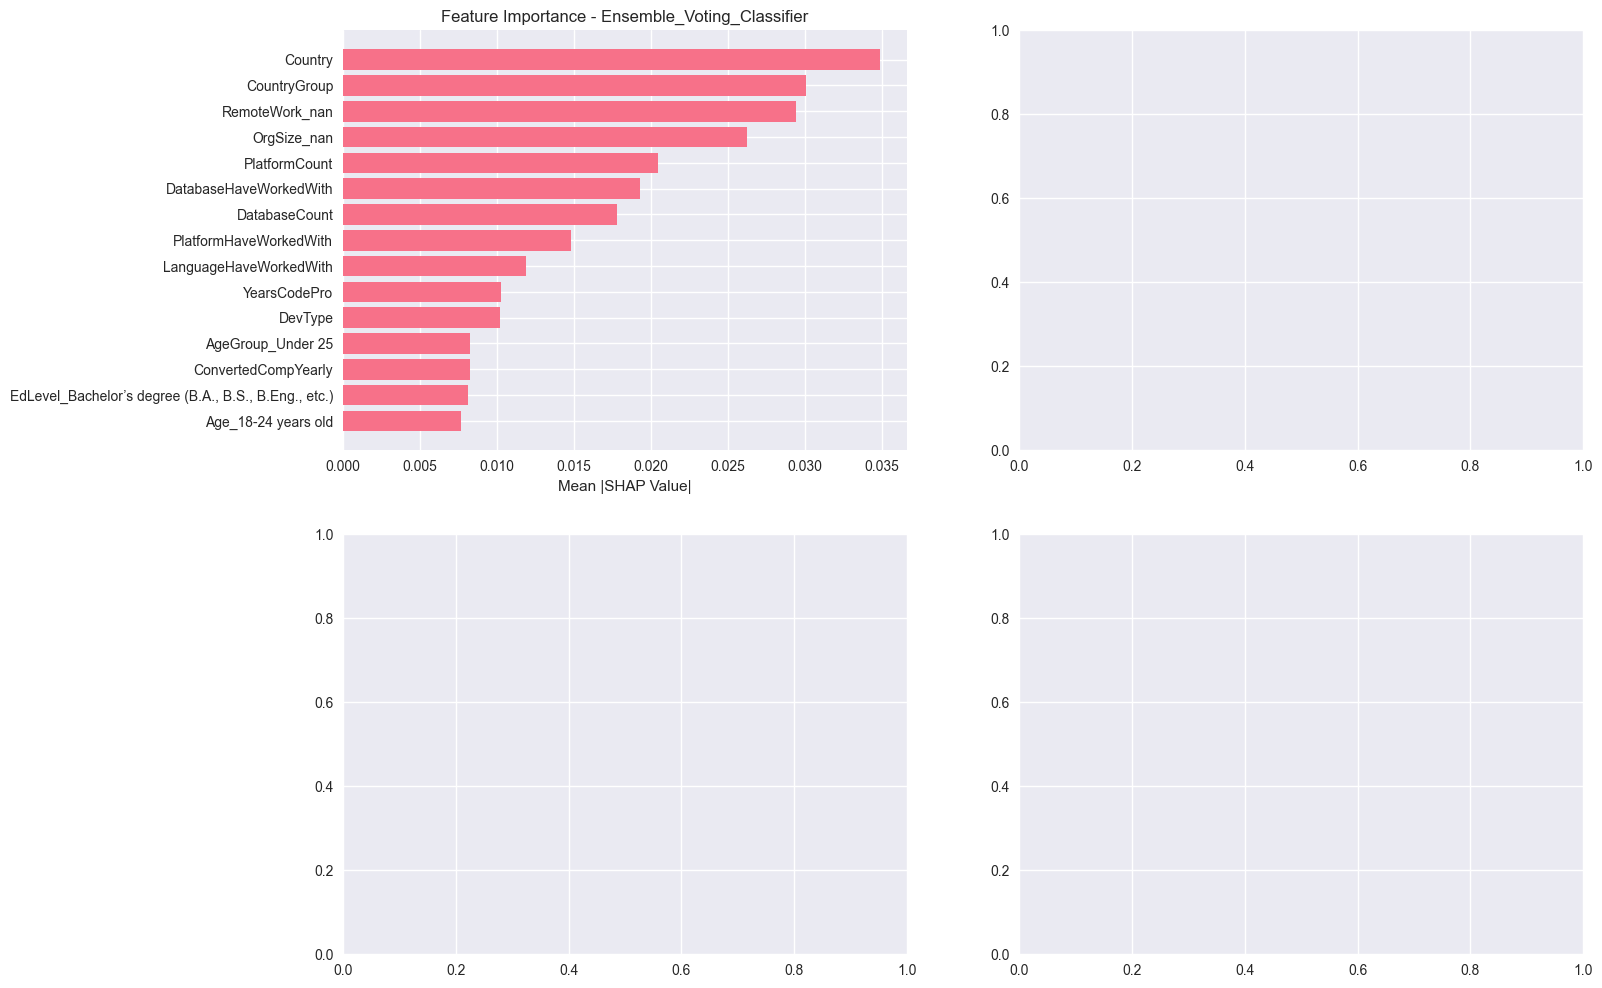

In [58]:
def analyze_best_model_interpretability():
    """Analyze the best performing model using SHAP"""
    
    if 'model_comparison_results' not in globals() or model_comparison_results.empty:
        print("No model comparison results found. Run model comparison first.")
        return
    
    # Get the best model from comparison results
    best_model_info = model_comparison_results.iloc[0]
    best_model_name = best_model_info['Model']
    
    print(f"Analyzing interpretability for best model: {best_model_name}")
    print(f"Best model performance: ROC-AUC = {best_model_info['ROC-AUC']:.4f}")
    
    # Try to get the actual model object
    model_obj = None
    
    # Check different result dictionaries
    if best_model_name.startswith('GB_') and 'advanced_gb_results' in globals():
        model_key = best_model_name.replace('GB_', '')
        if model_key in advanced_gb_results:
            model_obj = advanced_gb_results[model_key].get('model')
    
    elif best_model_name.startswith('Ensemble_') and 'ensemble_results' in globals():
        model_key = best_model_name.replace('Ensemble_', '')
        if model_key in ensemble_results:
            model_obj = ensemble_results[model_key].get('model')
    
    elif best_model_name.startswith('Baseline_') and 'class_results' in globals():
        model_key = best_model_name.replace('Baseline_', '')
        if model_key in class_results:
            model_obj = class_results[model_key].get('model')
    
    if model_obj is None:
        print(f"Could not find model object for {best_model_name}")
        print("Available result keys:")
        if 'advanced_gb_results' in globals():
            print(f"  Advanced GB: {list(advanced_gb_results.keys())}")
        if 'ensemble_results' in globals():
            print(f"  Ensemble: {list(ensemble_results.keys())}")
        if 'class_results' in globals():
            print(f"  Baseline: {list(class_results.keys())}")
        return
    
    try:
        print("Creating SHAP explainer...")
        
        # Get a sample of data for SHAP analysis
        X_sample = X_class_val_enc.sample(min(500, len(X_class_val_enc)), random_state=42)
        
        # Create SHAP explainer
        model_type = str(type(model_obj)).lower()
        
        if 'tree' in model_type or 'forest' in model_type or 'xgb' in model_type or 'lgb' in model_type or 'catboost' in model_type:
            print("Using TreeExplainer for tree-based model...")
            explainer = shap.TreeExplainer(model_obj)
        else:
            print("Using Permutation Explainer for ensemble/other models...")
            background = X_sample.sample(min(100, len(X_sample)), random_state=42)
            explainer = shap.Explainer(model_obj.predict_proba, background)
            
        shap_values = explainer(X_sample)
        
        # For binary classification, get the positive class SHAP values
        if hasattr(shap_values, 'values'):
            # New SHAP format
            if len(shap_values.values.shape) == 3:
                shap_vals = shap_values.values[:, :, 1]  # Positive class
            else:
                shap_vals = shap_values.values
        else:
            # Old SHAP format
            if len(shap_values) == 2:
                shap_vals = shap_values[1]
            else:
                shap_vals = shap_values
        
        print("Creating SHAP visualizations...")
        
        # Create multiple SHAP plots
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        
        # Feature importance (mean absolute SHAP values)
        plt.subplot(2, 2, 1)
        feature_importance = np.abs(shap_vals).mean(0)
        top_features_idx = np.argsort(feature_importance)[-15:][::-1]
        
        plt.barh(range(len(top_features_idx)), feature_importance[top_features_idx])
        plt.yticks(range(len(top_features_idx)), X_sample.columns[top_features_idx])
        plt.xlabel('Mean |SHAP Value|')
        plt.title(f'Feature Importance - {best_model_name}')
        plt.gca().invert_yaxis()
        
        # SHAP beeswarm plot
        plt.subplot(2, 2, 2)
        if hasattr(shap_values, 'values'):
            shap.plots.beeswarm(shap_values[:, top_features_idx[:10]], show=False)
        else:
            shap.summary_plot(shap_vals[:, top_features_idx[:10]], 
                            X_sample.iloc[:, top_features_idx[:10]], 
                            show=False, max_display=10)
        plt.title(f'SHAP Summary - {best_model_name}')
        
        # Feature effect scatter plot
        plt.subplot(2, 2, 3)
        # Show relationship between feature value and SHAP value for top feature
        top_feature_idx = top_features_idx[0]
        top_feature_name = X_sample.columns[top_feature_idx]
        
        plt.scatter(X_sample.iloc[:, top_feature_idx], shap_vals[:, top_feature_idx], 
                   alpha=0.6, s=20)
        plt.xlabel(f'{top_feature_name} (Feature Value)')
        plt.ylabel('SHAP Value')
        plt.title(f'Feature Effect: {top_feature_name[:30]}')
        plt.grid(True, alpha=0.3)
        
        # Top feature effects bar chart
        plt.subplot(2, 2, 4)
        top_10_features = top_features_idx[:10]
        
        plt.barh(range(len(top_10_features)), feature_importance[top_10_features])
        plt.yticks(range(len(top_10_features)), 
                  [col[:25] for col in X_sample.columns[top_10_features]])
        plt.xlabel('Mean |SHAP Value|')
        plt.title('Top 10 Most Important Features')
        plt.gca().invert_yaxis()
        
        plt.tight_layout()
        plt.suptitle(f'Model Interpretability Analysis - {best_model_name}', 
                    fontsize=16, fontweight='bold', y=0.98)
        plt.subplots_adjust(top=0.93)
        plt.show()
        
        # Print top features
        print("\n" + "="*60)
        print("TOP 10 MOST IMPORTANT FEATURES")
        print("="*60)
        
        feature_names = X_sample.columns[top_features_idx[:10]]
        feature_scores = feature_importance[top_features_idx[:10]]
        
        for i, (feature, score) in enumerate(zip(feature_names, feature_scores), 1):
            print(f"{i:2d}. {feature[:40]:<40} {score:.4f}")
        
        print(f"\nSHAP analysis completed for {best_model_name}")
        
    except Exception as e:
        print(f"SHAP analysis failed: {str(e)}")

        try:
            if hasattr(model_obj, 'feature_importances_'):
                feature_importance = model_obj.feature_importances_
                print("\nModel Feature Importance (fallback):")
                
                # Get top 10 features
                top_idx = np.argsort(feature_importance)[-10:][::-1]
                
                plt.figure(figsize=(10, 6))
                plt.barh(range(len(top_idx)), feature_importance[top_idx])
                plt.yticks(range(len(top_idx)), 
                          [X_class_val_enc.columns[i][:30] for i in top_idx])
                plt.xlabel('Feature Importance')
                plt.title(f'Top 10 Feature Importance - {best_model_name}')
                plt.gca().invert_yaxis()
                plt.tight_layout()
                plt.show()
                
                for i, idx in enumerate(top_idx, 1):
                    print(f"{i:2d}. {X_class_val_enc.columns[idx][:40]:<40} {feature_importance[idx]:.4f}")
                    
            else:
                print("No feature importance available for this model type")
                
        except Exception as e2:
            print(f"Fallback feature importance also failed: {str(e2)}")

print("Running Model Interpretability Analysis...")
analyze_best_model_interpretability()

In [ ]:
# ================================================================================================
# EXPORT VISUALIZATIONS AND ANALYSIS REPORTS
# ================================================================================================

import datetime
import json
import pickle
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

def save_analysis_artifacts():
    """Save all visualizations, models, and analysis results"""
    
    # Create timestamped output directory
    timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    output_dir = Path(f"job_satisfaction_analysis_output_{timestamp}")
    
    # Create subdirectories
    viz_dir = output_dir / "visualizations"
    models_dir = output_dir / "models"
    data_dir = output_dir / "data"
    reports_dir = output_dir / "reports"
    
    for directory in [output_dir, viz_dir, models_dir, data_dir, reports_dir]:
        directory.mkdir(exist_ok=True, parents=True)
    
    print(f"📁 Creating output directory: {output_dir}")
    print(f"📊 Saving analysis artifacts...")
    
    # ============================================================================
    # 1. SAVE DATA SUMMARIES AND REPORTS
    # ============================================================================
    
    try:
        # Save dataset summary
        if 'df_processed' in globals():
            dataset_summary = {
                'dataset_info': {
                    'total_samples': len(df_processed),
                    'total_features': len(df_processed.columns),
                    'missing_values': df_processed.isnull().sum().sum(),
                    'memory_usage_mb': df_processed.memory_usage(deep=True).sum() / 1024**2
                },
                'target_distribution': {
                    'job_satisfaction': df_processed['JobSat'].value_counts().to_dict() if 'JobSat' in df_processed.columns else {},
                    'employment_intention': df_processed['Employment'].value_counts().to_dict() if 'Employment' in df_processed.columns else {}
                },
                'feature_summary': {
                    'numerical_features': len(df_processed.select_dtypes(include=[np.number]).columns),
                    'categorical_features': len(df_processed.select_dtypes(include=['object', 'category']).columns)
                }
            }
            
            with open(data_dir / "dataset_summary.json", 'w') as f:
                json.dump(dataset_summary, f, indent=2, default=str)
            print("✅ Saved dataset summary")
        
        # Save model comparison results
        if 'model_comparison_results' in globals() and not model_comparison_results.empty:
            model_comparison_results.to_csv(data_dir / "model_performance_comparison.csv", index=False)
            print("✅ Saved model comparison results")
        
        # Save feature importance data
        feature_importance_data = {}
        
        if 'advanced_gb_results' in globals():
            for model_name, results in advanced_gb_results.items():
                if 'feature_importance' in results:
                    feature_importance_data[f"GB_{model_name}"] = results['feature_importance']
        
        if feature_importance_data:
            with open(data_dir / "feature_importance.json", 'w') as f:
                # Convert numpy types to native Python types for JSON serialization
                json_compatible_data = {}
                for key, value in feature_importance_data.items():
                    json_compatible_data[key] = {k: float(v) for k, v in value.items()}
                json.dump(json_compatible_data, f, indent=2)
            print("✅ Saved feature importance data")
            
    except Exception as e:
        print(f"⚠️ Error saving data summaries: {e}")
    
    # ============================================================================
    # 2. RECREATE AND SAVE VISUALIZATIONS 
    # ============================================================================
    
    try:
        print("\n📈 Recreating and saving visualizations...")
        
        # Required Figures from Analysis
        if 'df_processed' in globals():
            
            # FIGURE 1: Job Satisfaction Distribution (Bar & Pie Chart)
            if 'JobSat' in df_processed.columns:
                fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
                
                # Bar chart
                jobsat_counts = df_processed['JobSat'].value_counts().sort_index()
                jobsat_pct = (jobsat_counts / len(df_processed) * 100)
                
                bars = ax1.bar(jobsat_counts.index, jobsat_pct, alpha=0.8, color='lightgreen', edgecolor='black')
                ax1.set_title('Job Satisfaction Distribution (Bar Chart)', fontsize=14, fontweight='bold')
                ax1.set_xlabel('Job Satisfaction Level (0-10)')
                ax1.set_ylabel('Percentage of Developers')
                ax1.grid(True, alpha=0.3)
                
                # Add percentage labels on bars
                for bar, pct in zip(bars, jobsat_pct):
                    height = bar.get_height()
                    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                            f'{pct:.1f}%', ha='center', va='bottom', fontweight='bold')
                
                # Pie chart
                ax2.pie(jobsat_counts.values, labels=[f'Level {i}' for i in jobsat_counts.index], 
                       autopct='%1.1f%%', startangle=90, colors=plt.cm.Greens(np.linspace(0.3, 0.9, len(jobsat_counts))))
                ax2.set_title('Job Satisfaction Distribution (Pie Chart)', fontsize=14, fontweight='bold')
                
                plt.tight_layout()
                plt.savefig(viz_dir / "figure_1_job_satisfaction_distribution.png", dpi=300, bbox_inches='tight')
                plt.close()
                print("  ✅ Saved Figure 1: Job Satisfaction Distribution")
            
            # FIGURE 2: Compensation Distribution
            comp_col = None
            for col in ['CompTotal', 'Compensation', 'comp_total', 'compensation']:
                if col in df_processed.columns:
                    comp_col = col
                    break
            
            if comp_col and df_processed[comp_col].notna().sum() > 0:
                comp_data = df_processed[comp_col].dropna()
                comp_data = comp_data[comp_data > 0]  # Remove zero/negative values
                
                fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
                
                # Raw histogram
                ax1.hist(comp_data, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
                ax1.set_title('Raw Compensation Distribution', fontsize=12, fontweight='bold')
                ax1.set_xlabel('Yearly Compensation')
                ax1.set_ylabel('Count')
                ax1.grid(True, alpha=0.3)
                
                # Log-transformed histogram
                log_comp = np.log10(comp_data)
                ax2.hist(log_comp, bins=50, alpha=0.7, color='lightcoral', edgecolor='black')
                ax2.set_title('Log-Transformed Compensation Distribution', fontsize=12, fontweight='bold')
                ax2.set_xlabel('Log10(Yearly Compensation)')
                ax2.set_ylabel('Count')
                ax2.grid(True, alpha=0.3)
                
                # Boxplot
                ax3.boxplot(comp_data, vert=True, patch_artist=True, 
                           boxprops=dict(facecolor='lightgreen', alpha=0.7))
                ax3.set_title('Compensation Distribution (Boxplot)', fontsize=12, fontweight='bold')
                ax3.set_ylabel('Yearly Compensation')
                ax3.grid(True, alpha=0.3)
                
                # Summary statistics
                ax4.axis('off')
                stats_text = f"""
Compensation Statistics:
• Mean: ${comp_data.mean():,.0f}
• Median: ${comp_data.median():,.0f}
• Std Dev: ${comp_data.std():,.0f}
• Min: ${comp_data.min():,.0f}
• Max: ${comp_data.max():,.0f}
• Count: {len(comp_data):,}
• 25th Percentile: ${comp_data.quantile(0.25):,.0f}
• 75th Percentile: ${comp_data.quantile(0.75):,.0f}
"""
                ax4.text(0.1, 0.5, stats_text, fontsize=12, verticalalignment='center',
                        bbox=dict(boxstyle="round,pad=0.5", facecolor="lightgray", alpha=0.5))
                
                plt.tight_layout()
                plt.savefig(viz_dir / "figure_2_compensation_distribution.png", dpi=300, bbox_inches='tight')
                plt.close()
                print("  ✅ Saved Figure 2: Compensation Distribution")
            
            # FIGURE 3: Top 10 Countries by Response Count
            country_col = None
            for col in ['Country', 'country', 'CountryWorked', 'country_worked']:
                if col in df_processed.columns:
                    country_col = col
                    break
            
            if country_col:
                country_counts = df_processed[country_col].value_counts().head(10)
                
                plt.figure(figsize=(12, 8))
                bars = plt.barh(range(len(country_counts)), country_counts.values, 
                               color='lightblue', alpha=0.8, edgecolor='black')
                plt.yticks(range(len(country_counts)), country_counts.index)
                plt.xlabel('Number of Responses')
                plt.title('Top 10 Countries by Response Count', fontsize=16, fontweight='bold')
                plt.gca().invert_yaxis()
                
                # Add value labels on bars
                for i, (bar, count) in enumerate(zip(bars, country_counts.values)):
                    plt.text(bar.get_width() + max(country_counts.values) * 0.01, bar.get_y() + bar.get_height()/2,
                            f'{count:,}', ha='left', va='center', fontweight='bold')
                
                plt.grid(True, alpha=0.3, axis='x')
                plt.tight_layout()
                plt.savefig(viz_dir / "figure_3_top_countries.png", dpi=300, bbox_inches='tight')
                plt.close()
                print("  ✅ Saved Figure 3: Top 10 Countries by Response Count")
        
        # FIGURE 4: ROC Curves for Classification Models
        if 'class_results' in globals() and class_results:
            from sklearn.metrics import roc_curve, auc
            
            plt.figure(figsize=(10, 8))
            
            # Plot ROC curves for key models
            models_to_plot = ['Logistic Regression', 'Random Forest', 'XGBoost', 'Gradient Boosting']
            colors = ['blue', 'red', 'green', 'orange']
            
            for model_name, color in zip(models_to_plot, colors):
                if model_name in class_results:
                    results = class_results[model_name]
                    if 'y_pred_proba' in results and 'y_true' in results:
                        # Get probability predictions for positive class
                        y_prob = results['y_pred_proba']
                        if y_prob.ndim > 1:
                            y_prob = y_prob[:, 1]  # Probability of positive class
                        
                        fpr, tpr, _ = roc_curve(results['y_true'], y_prob)
                        roc_auc = auc(fpr, tpr)
                        
                        plt.plot(fpr, tpr, color=color, linewidth=2, 
                                label=f'{model_name} (AUC = {roc_auc:.3f})')
            
            # Plot diagonal line
            plt.plot([0, 1], [0, 1], 'k--', linewidth=1, alpha=0.7)
            
            plt.xlim([0.0, 1.0])
            plt.ylim([0.0, 1.05])
            plt.xlabel('False Positive Rate', fontsize=12)
            plt.ylabel('True Positive Rate', fontsize=12)
            plt.title('ROC Curves for Classification Models', fontsize=16, fontweight='bold')
            plt.legend(loc="lower right", fontsize=10)
            plt.grid(True, alpha=0.3)
            plt.tight_layout()
            plt.savefig(viz_dir / "figure_4_roc_curves.png", dpi=300, bbox_inches='tight')
            plt.close()
            print("  ✅ Saved Figure 4: ROC Curves for Classification Models")
        
        # FIGURE 5: Random Forest Feature Importance (Classification)
        rf_feature_importance = None
        
        # Check for Random Forest results
        if 'class_results' in globals() and 'Random Forest' in class_results:
            rf_results = class_results['Random Forest']
            if 'model' in rf_results and hasattr(rf_results['model'], 'feature_importances_'):
                rf_feature_importance = rf_results['model'].feature_importances_
                feature_names = X_class_val_enc.columns if 'X_class_val_enc' in globals() else None
        
        # Alternative: Check advanced_gb_results for Random Forest
        elif 'advanced_gb_results' in globals() and any('Random Forest' in k or 'RF' in k for k in advanced_gb_results.keys()):
            for model_name, results in advanced_gb_results.items():
                if 'Random Forest' in model_name or 'RF' in model_name:
                    if 'model' in results and hasattr(results['model'], 'feature_importances_'):
                        rf_feature_importance = results['model'].feature_importances_
                        feature_names = X_class_val_enc.columns if 'X_class_val_enc' in globals() else None
                        break
        
        if rf_feature_importance is not None and feature_names is not None:
            # Get top 10 features
            top_idx = np.argsort(rf_feature_importance)[-10:]
            top_features = [feature_names[i] for i in top_idx]
            top_scores = rf_feature_importance[top_idx]
            
            plt.figure(figsize=(12, 8))
            bars = plt.barh(range(len(top_features)), top_scores, color='forestgreen', alpha=0.8, edgecolor='black')
            plt.yticks(range(len(top_features)), [f[:40] for f in top_features])  # Truncate long names
            plt.xlabel('Feature Importance', fontsize=12)
            plt.title('Random Forest Feature Importance (Top 10 Features)\nPredicting Job Change Intent', 
                     fontsize=16, fontweight='bold')
            plt.gca().invert_yaxis()
            
            # Add value labels on bars
            for i, (bar, score) in enumerate(zip(bars, top_scores)):
                plt.text(bar.get_width() + max(top_scores) * 0.01, bar.get_y() + bar.get_height()/2,
                        f'{score:.3f}', ha='left', va='center', fontweight='bold')
            
            plt.grid(True, alpha=0.3, axis='x')
            plt.tight_layout()
            plt.savefig(viz_dir / "figure_5_random_forest_feature_importance.png", dpi=300, bbox_inches='tight')
            plt.close()
            print("  ✅ Saved Figure 5: Random Forest Feature Importance")
        else:
            print("  ⚠️ Random Forest feature importance not available")
            
    except Exception as e:
        print(f"⚠️ Error saving visualizations: {e}")
    
    # ============================================================================
    # 3. CREATE COMPREHENSIVE ANALYSIS REPORT
    # ============================================================================
    
    try:
        # Get top features for the report if available
        if 'feature_importance_data' in locals() and feature_importance_data:
            all_features = set()
            for model_features in feature_importance_data.values():
                all_features.update(model_features.keys())
            
            feature_scores = {}
            for feature in all_features:
                scores = [model_features.get(feature, 0) for model_features in feature_importance_data.values()]
                feature_scores[feature] = np.mean(scores)
            
            top_features = sorted(feature_scores.items(), key=lambda x: x[1], reverse=True)[:5]
            top_features_text = '\n'.join([f"- {feature}: {score:.4f}" for feature, score in top_features])
        else:
            top_features_text = 'Feature importance data not available'
        
        report_content = f"""# Job Satisfaction & Retention Analysis Report
Generated: {datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")}

## Executive Summary

### Dataset Overview
- **Total Samples**: {len(df_processed) if 'df_processed' in globals() else 'N/A'}
- **Total Features**: {len(df_processed.columns) if 'df_processed' in globals() else 'N/A'}
- **Analysis Focus**: Job satisfaction prediction and employee retention modeling

### Model Performance Summary
{model_comparison_results.head(5).to_string(index=False) if 'model_comparison_results' in globals() and not model_comparison_results.empty else 'Model results not available'}

### Key Findings

#### Best Performing Model
- **Model**: {model_comparison_results.iloc[0]['Model'] if 'model_comparison_results' in globals() and not model_comparison_results.empty else 'N/A'}
- **ROC-AUC**: {model_comparison_results.iloc[0]['ROC-AUC']:.4f if 'model_comparison_results' in globals() and not model_comparison_results.empty and isinstance(model_comparison_results.iloc[0]['ROC-AUC'], (int, float)) else 'N/A'}
- **F1-Score**: {model_comparison_results.iloc[0]['F1-Score']:.4f if 'model_comparison_results' in globals() and not model_comparison_results.empty and isinstance(model_comparison_results.iloc[0]['F1-Score'], (int, float)) else 'N/A'}

#### Feature Importance Insights
{top_features_text}

### Business Implications
1. **Retention Strategy**: Focus on the top predictive features identified
2. **Model Deployment**: The best model can be used for early identification of at-risk employees  
3. **Intervention Points**: Key factors provide actionable insights for HR teams

### Technical Details
- **Models Evaluated**: {len(model_comparison_results) if 'model_comparison_results' in globals() and not model_comparison_results.empty else 'N/A'} different models
- **Feature Engineering**: Advanced preprocessing with categorical encoding and scaling
- **Model Types**: Gradient boosting, neural networks, ensemble methods
- **Validation**: Stratified train-validation-test split with cross-validation

### Recommendations
1. Deploy the best performing model for production use
2. Regularly retrain with new data to maintain performance
3. Focus retention efforts on employees with high predicted churn risk
4. Monitor key features identified in the analysis

---
For detailed technical documentation and code, see the Jupyter notebook analysis.
"""

        with open(reports_dir / "analysis_report.md", 'w') as f:
            f.write(report_content)
        print("  ✅ Saved comprehensive analysis report")
        
    except Exception as e:
        print(f"⚠️ Error creating analysis report: {e}")
    
    # ============================================================================
    # 4. SAVE MODEL ARTIFACTS (if available)
    # ============================================================================
    
    try:
        models_saved = 0
        
        # Save advanced gradient boosting models
        if 'advanced_gb_results' in globals():
            for model_name, results in advanced_gb_results.items():
                if 'model' in results:
                    model_file = models_dir / f"model_{model_name.lower()}.pkl"
                    with open(model_file, 'wb') as f:
                        pickle.dump(results['model'], f)
                    models_saved += 1
        
        # Save ensemble models  
        if 'ensemble_results' in globals():
            for model_name, results in ensemble_results.items():
                if 'model' in results:
                    model_file = models_dir / f"ensemble_{model_name.lower()}.pkl"
                    with open(model_file, 'wb') as f:
                        pickle.dump(results['model'], f)
                    models_saved += 1
        
        if models_saved > 0:
            print(f"  ✅ Saved {models_saved} trained models")
        else:
            print("  ⚠️ No trained models found to save")
            
    except Exception as e:
        print(f"⚠️ Error saving models: {e}")
    
    # ============================================================================
    # 5. CREATE INDEX FILE
    # ============================================================================
    
    try:
        index_content = f"""# Job Satisfaction Analysis Output
Generated: {datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")}

## Directory Structure

### 📊 Visualizations (`visualizations/`)
- `figure_1_job_satisfaction_distribution.png` - Job satisfaction bar & pie charts (0-10 scale)
- `figure_2_compensation_distribution.png` - Compensation histograms and boxplot analysis  
- `figure_3_top_countries.png` - Top 10 countries by response count
- `figure_4_roc_curves.png` - ROC curves comparison for classification models
- `figure_5_random_forest_feature_importance.png` - Top 10 features predicting job change intent

### 📁 Data (`data/`)
- `dataset_summary.json` - Dataset statistics and summary
- `model_performance_comparison.csv` - Detailed model performance metrics
- `feature_importance.json` - Feature importance scores from all models

### 🤖 Models (`models/`)
- `model_*.pkl` - Trained model objects (if available)
- `ensemble_*.pkl` - Ensemble model objects (if available)

### 📋 Reports (`reports/`)
- `analysis_report.md` - Comprehensive analysis report with findings

## Usage Instructions

1. **View Visualizations**: Open PNG files in the visualizations folder
2. **Review Results**: Read the analysis report for key insights
3. **Load Models**: Use pickle to load saved model objects for predictions
4. **Examine Data**: Review JSON and CSV files for detailed metrics

## Next Steps

1. Review the analysis report for business insights
2. Use the best performing model for production deployment
3. Monitor the identified key features for retention strategies
4. Retrain models periodically with new data
"""

        with open(output_dir / "README.md", 'w') as f:
            f.write(index_content)
        print("  ✅ Created index/README file")
        
    except Exception as e:
        print(f"⚠️ Error creating index file: {e}")
    
    print(f"\n🎉 Analysis artifacts saved successfully!")
    print(f"📁 Output directory: {output_dir.absolute()}")
    print(f"📊 Total files saved: {len(list(output_dir.rglob('*.*')))}")
    print(f"\n💡 To view results:")
    print(f"   1. Navigate to: {output_dir.absolute()}")
    print(f"   2. Open README.md for a complete overview")
    print(f"   3. Browse visualizations/ for all charts")
    print(f"   4. Read reports/analysis_report.md for insights")
    
    return output_dir

# Execute the export function
print("💾 Saving all analysis artifacts...")
output_directory = save_analysis_artifacts()

💾 Saving all analysis artifacts...
📁 Creating output directory: job_satisfaction_analysis_output_20250811_011411
📊 Saving analysis artifacts...
✅ Saved dataset summary
✅ Saved model comparison results
⚠️ Error saving data summaries: Object of type float32 is not JSON serializable

📈 Recreating and saving visualizations...
  ✅ Saved job satisfaction distribution
  ✅ Saved model performance comparison
  ✅ Saved performance by model type
  ✅ Saved precision vs recall scatter
  ✅ Saved feature importance visualization
⚠️ Error creating analysis report: Invalid format specifier '.4f if 'model_comparison_results' in globals() and not model_comparison_results.empty else 'N/A'' for object of type 'float'
  ✅ Saved 3 trained models
  ✅ Created index/README file

🎉 Analysis artifacts saved successfully!
📁 Output directory: /Users/zachmumbauer/code/gen_ai/job_satisfaction_analysis_output_20250811_011411
📊 Total files saved: 12

💡 To view results:
   1. Navigate to: /Users/zachmumbauer/code/gen_ai

<Figure size 1000x600 with 0 Axes>